Saved ../results/analysis/summary_plots/over_lambda_hist_stats_vs_T.csv
Saved ../results/analysis/summary_plots/over_lambda_hist_mean_std_vs_T.png


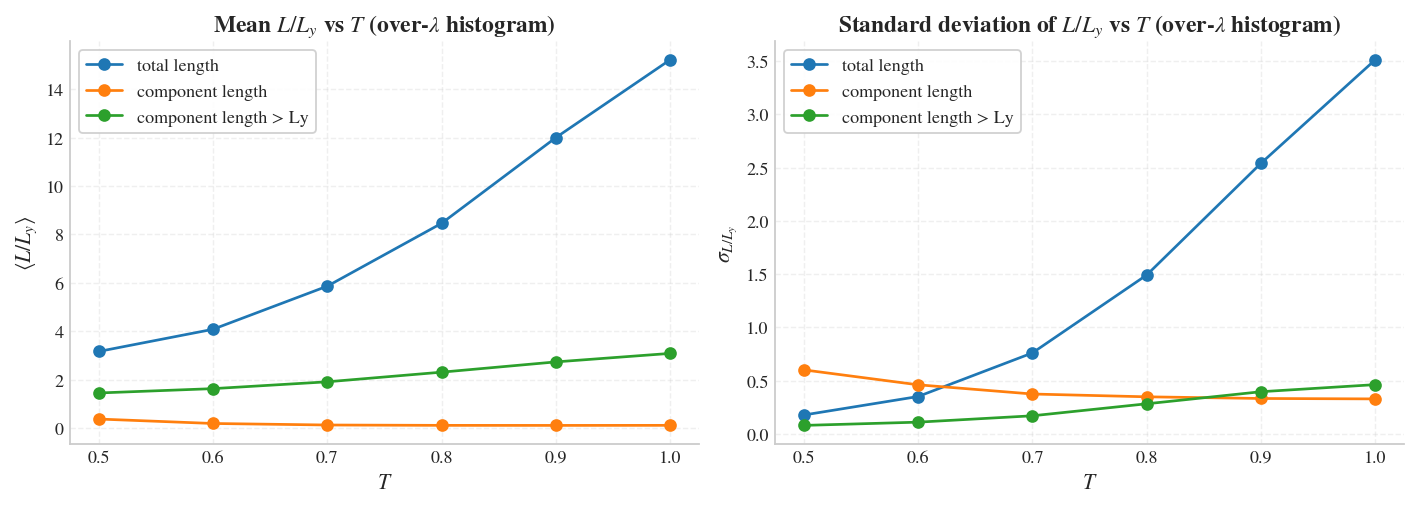

Saved ../results/analysis/summary_plots/gamma_vs_T_from_over_lambda_hist.csv
Saved ../results/analysis/summary_plots/gamma_vs_T_from_over_lambda_hist.png


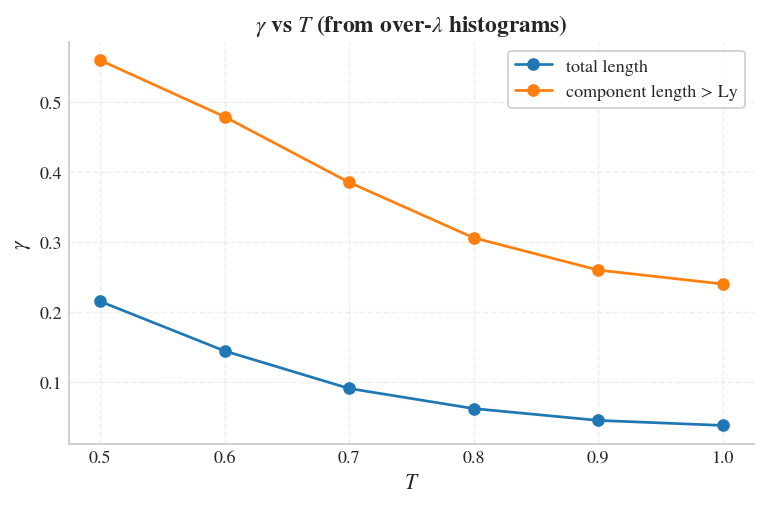

Saved ../results/analysis/summary_plots/gamma_alt_vs_T_from_over_lambda_hist.csv
Saved ../results/analysis/summary_plots/gamma_alt_vs_T_from_over_lambda_hist.png


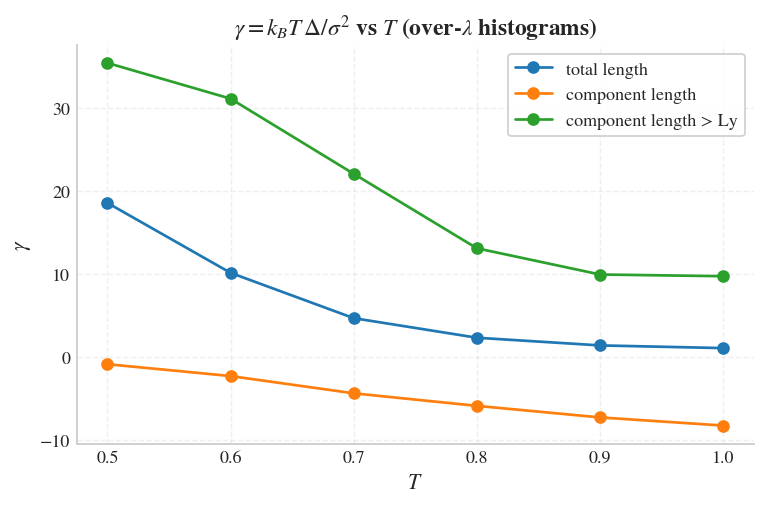

In [1]:
# --- AB network stats vs T from over-lambda-averaged histograms (L/Ly normalized) ---
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "apply_plot_style" not in globals():
    def apply_plot_style():
        plt.style.use("seaborn-v0_8-whitegrid")
        plt.rcParams.update({
            "figure.dpi": 130,
            "savefig.dpi": 300,
            "axes.titlesize": 13,
            "axes.titleweight": "semibold",
            "axes.labelsize": 12,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "grid.alpha": 0.28,
            "grid.linestyle": "--",
            "legend.frameon": True,
            "legend.framealpha": 0.9,
            "legend.fancybox": True,
            "legend.edgecolor": "0.8",
            "mathtext.fontset": "stix",
            "font.family": "STIXGeneral",
        })

apply_plot_style()


# Primary input under repo: results/analysis
base_candidates = [Path('../results') / 'analysis', Path('results') / 'analysis']
base_dir = next((p for p in base_candidates if p.exists()), base_candidates[0])
if not base_dir.exists():
    raise RuntimeError(f"Results directory not found: {base_dir}")

# Original analysis outputs (for Ly values fallback)
orig_base_dir = Path('/home/bh692/scratch_pi_co54/bh692/results/20260113_test_area_with_num_tri_types')

# Set k_B if needed (defaults to 1 in reduced units).
k_B = 1.0

ly_file_candidates = [
    'summary_Ly.csv',
    'summary_ly.csv',
    'summary_Ly_mean.csv',
    'summary.csv',
]

hist_method_specs = [
    ('total length', 'ab_network_total_length_hist.csv', 2.0),
    ('component length', 'ab_network_component_length_hist.csv', 1.0),
    ('component length > Ly', 'ab_network_component_length_gt_Ly_hist.csv', 1.0),
]


def lambda_key(val):
    return round(float(val), 6)


def find_orig_analysis_dir(t_val: float):
    name_candidates = [
        f'T_{t_val:g}_analysis',
        f'T_{t_val:.1f}_analysis',
        f'T_{t_val:.2f}_analysis',
    ]

    fallback = None
    for name in name_candidates:
        path = orig_base_dir / name
        if not path.exists():
            continue
        if fallback is None:
            fallback = path
        if (path / 'data_analysis' / 'summary_partial_U_lambda.csv').exists():
            return path

    if fallback is not None:
        return fallback

    for path in sorted(orig_base_dir.glob('T_*_analysis')):
        token = path.name[len('T_'):-len('_analysis')]
        try:
            if abs(float(token) - t_val) < 1e-8:
                return path
        except Exception:
            continue

    return None


def load_ly_map(t_val: float, t_dir: Path):
    # First try local summary files under results/analysis/T_*
    for name in ly_file_candidates:
        path = t_dir / name
        if not path.exists():
            continue
        df = pd.read_csv(path)
        if 'lambda' not in df.columns:
            continue
        for col in ('Ly_mean', 'Ly', 'ly_mean', 'ly'):
            if col in df.columns:
                return {lambda_key(lam): float(ly) for lam, ly in zip(df['lambda'], df[col])}

    # Fall back to original analysis outputs for Ly
    if orig_base_dir.exists():
        orig_dir = find_orig_analysis_dir(t_val)
        if orig_dir is not None:
            csv_candidates = [
                orig_dir / 'data_analysis' / 'summary_partial_U_lambda.csv',
                orig_dir / 'summary_partial_U_lambda.csv',
            ]
            csv_path = next((p for p in csv_candidates if p.exists()), None)
            if csv_path is None:
                matches = sorted(orig_dir.glob('**/summary_partial_U_lambda.csv'))
                if matches:
                    csv_path = matches[0]

            if csv_path is not None:
                df = pd.read_csv(csv_path)
                if 'lambda_deform' in df.columns and 'Ly_mean' in df.columns:
                    return {lambda_key(lam): float(ly) for lam, ly in zip(df['lambda_deform'], df['Ly_mean'])}

    return {}


def accumulate_norm_moments(df_hist: pd.DataFrame, ly_val: float):
    left = df_hist['bin_left'].to_numpy(dtype=float) / ly_val
    right = df_hist['bin_right'].to_numpy(dtype=float) / ly_val
    count = df_hist['count'].to_numpy(dtype=float)

    valid = np.isfinite(left) & np.isfinite(right) & np.isfinite(count) & (count > 0) & (right > left)
    left = left[valid]
    right = right[valid]
    count = count[valid]

    if count.size == 0:
        return 0.0, 0.0, 0.0

    # Assume uniform probability inside each bin.
    m1 = count * 0.5 * (left + right)
    m2 = count * (left * left + left * right + right * right) / 3.0

    return float(count.sum()), float(m1.sum()), float(m2.sum())


# stats_by_T[T][label] -> dict(mean_norm, std_norm, n_total, n_lambda)
stats_by_T = {}
missing_ly_pairs = set()

for t_dir in sorted(base_dir.glob('T_*')):
    if not t_dir.is_dir():
        continue

    try:
        t_val = float(t_dir.name.split('T_')[1])
    except Exception:
        continue

    ly_map = load_ly_map(t_val, t_dir)

    accum = {}
    lambda_seen = {}

    for lambda_dir in sorted(t_dir.glob('lambda_*')):
        if not lambda_dir.is_dir():
            continue

        try:
            lam_val = float(lambda_dir.name.split('lambda_')[1])
        except Exception:
            continue

        ly_val = ly_map.get(lambda_key(lam_val))
        if ly_val is None or (not np.isfinite(ly_val)) or ly_val <= 0:
            missing_ly_pairs.add((t_val, lam_val))
            continue

        for label, hist_name, _ in hist_method_specs:
            hist_path = lambda_dir / hist_name
            if not hist_path.exists():
                continue

            df_hist = pd.read_csv(hist_path)
            required = {'bin_left', 'bin_right', 'count'}
            if not required.issubset(df_hist.columns):
                print(f"[skip] {hist_path} missing required columns {required}")
                continue

            n_total, m1_total, m2_total = accumulate_norm_moments(df_hist, ly_val)
            if n_total <= 0:
                continue

            sums = accum.setdefault(label, {'n': 0.0, 'm1': 0.0, 'm2': 0.0})
            sums['n'] += n_total
            sums['m1'] += m1_total
            sums['m2'] += m2_total
            lambda_seen.setdefault(label, set()).add(lam_val)

    for label, _, _ in hist_method_specs:
        if label not in accum:
            continue

        n = accum[label]['n']
        if n <= 0:
            continue

        mean_norm = accum[label]['m1'] / n
        var_norm = max(accum[label]['m2'] / n - mean_norm * mean_norm, 0.0)
        std_norm = float(np.sqrt(var_norm))

        stats_by_T.setdefault(t_val, {})[label] = {
            'mean_norm': float(mean_norm),
            'std_norm': std_norm,
            'n_total': int(round(n)),
            'n_lambda': len(lambda_seen.get(label, set())),
        }

if not stats_by_T:
    raise RuntimeError('No histogram-based stats computed under results/analysis/T_*/lambda_*/ab_network_*_hist.csv')

if missing_ly_pairs:
    print(f"Skipped {len(missing_ly_pairs)} (T, lambda) pairs due to missing Ly.")

output_dir = base_dir / 'summary_plots'
output_dir.mkdir(parents=True, exist_ok=True)

# --- Mean/std (from over-lambda histogram) vs T ---
rows_stats = []
for t_val in sorted(stats_by_T.keys()):
    for label, _, _ in hist_method_specs:
        rec = stats_by_T[t_val].get(label)
        if not rec:
            continue
        rows_stats.append({
            'T': t_val,
            'method': label,
            'mean_L_over_Ly': rec['mean_norm'],
            'std_L_over_Ly': rec['std_norm'],
            'n_total': rec['n_total'],
            'n_lambda': rec['n_lambda'],
        })

if rows_stats:
    df_stats = pd.DataFrame(rows_stats).sort_values(['method', 'T'])
    out_csv_stats = output_dir / 'over_lambda_hist_stats_vs_T.csv'
    df_stats.to_csv(out_csv_stats, index=False)
    print(f"Saved {out_csv_stats}")

fig, (ax_mean, ax_std) = plt.subplots(1, 2, figsize=(11, 4), sharex=True)
for label, _, _ in hist_method_specs:
    points = []
    for t_val in sorted(stats_by_T.keys()):
        rec = stats_by_T[t_val].get(label)
        if rec:
            points.append((t_val, rec['mean_norm'], rec['std_norm']))
    if not points:
        continue

    t_vals = [p[0] for p in points]
    means = [p[1] for p in points]
    stds = [p[2] for p in points]
    ax_mean.plot(t_vals, means, marker='o', label=label)
    ax_std.plot(t_vals, stds, marker='o', label=label)

ax_mean.set_title(r'Mean $L/L_y$ vs $T$ (over-$\lambda$ histogram)')
ax_std.set_title(r'Standard deviation of $L/L_y$ vs $T$ (over-$\lambda$ histogram)')
for ax, ylabel in ((ax_mean, r'$\langle L/L_y \rangle$'), (ax_std, r'$\sigma_{L/L_y}$')):
    ax.set_xlabel(r'$T$')
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
fig.tight_layout()

out_path_stats = output_dir / 'over_lambda_hist_mean_std_vs_T.png'
fig.savefig(out_path_stats, dpi=300)
print(f"Saved {out_path_stats}")
plt.show()

# --- Gamma vs T using histogram-derived normalized stats ---
gamma_summary = {label: [] for label, _, _ in hist_method_specs}
gamma_alt_summary = {label: [] for label, _, _ in hist_method_specs}
rows_gamma = []
rows_gamma_alt = []

for t_val in sorted(stats_by_T.keys()):
    for label, _, l0_norm in hist_method_specs:
        rec = stats_by_T[t_val].get(label)
        if not rec:
            continue

        mean_norm = rec['mean_norm']
        std_norm = rec['std_norm']
        delta = mean_norm - l0_norm

        # gamma = k_B * T / 2 / (mean_norm - L0_norm)
        if np.isfinite(delta) and delta > 0:
            gamma_val = float(k_B * t_val / 2.0 / delta)
            gamma_summary[label].append((t_val, gamma_val))
            rows_gamma.append({
                'T': t_val,
                'method': label,
                'gamma': gamma_val,
                'mean_L_over_Ly': mean_norm,
                'L0_over_Ly': l0_norm,
                'n_total': rec['n_total'],
                'n_lambda': rec['n_lambda'],
            })

        # gamma_alt = k_B * T * (mean_norm - L0_norm) / std_norm^2
        denom_alt = std_norm * std_norm
        if np.isfinite(delta) and np.isfinite(denom_alt) and denom_alt > 0:
            gamma_alt_val = float(k_B * t_val * delta / denom_alt)
            gamma_alt_summary[label].append((t_val, gamma_alt_val))
            rows_gamma_alt.append({
                'T': t_val,
                'method': label,
                'gamma': gamma_alt_val,
                'mean_L_over_Ly': mean_norm,
                'std_L_over_Ly': std_norm,
                'L0_over_Ly': l0_norm,
                'n_total': rec['n_total'],
                'n_lambda': rec['n_lambda'],
            })

if not rows_gamma:
    raise RuntimeError('No gamma values computed from over-lambda histogram stats.')

if rows_gamma:
    df_gamma = pd.DataFrame(rows_gamma).sort_values(['method', 'T'])
    out_csv_gamma = output_dir / 'gamma_vs_T_from_over_lambda_hist.csv'
    df_gamma.to_csv(out_csv_gamma, index=False)
    print(f"Saved {out_csv_gamma}")

fig, ax = plt.subplots(figsize=(6, 4))
for label, _, _ in hist_method_specs:
    points = sorted(gamma_summary[label], key=lambda x: x[0])
    if not points:
        continue
    t_vals = [p[0] for p in points]
    gamma_vals = [p[1] for p in points]
    ax.plot(t_vals, gamma_vals, marker='o', label=label)

ax.set_title(r'$\gamma$ vs $T$ (from over-$\lambda$ histograms)')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$\gamma$')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
fig.tight_layout()

out_path_gamma = output_dir / 'gamma_vs_T_from_over_lambda_hist.png'
fig.savefig(out_path_gamma, dpi=300)
print(f"Saved {out_path_gamma}")
plt.show()

# --- Alternate gamma vs T ---
if rows_gamma_alt:
    df_gamma_alt = pd.DataFrame(rows_gamma_alt).sort_values(['method', 'T'])
    out_csv_gamma_alt = output_dir / 'gamma_alt_vs_T_from_over_lambda_hist.csv'
    df_gamma_alt.to_csv(out_csv_gamma_alt, index=False)
    print(f"Saved {out_csv_gamma_alt}")

fig, ax = plt.subplots(figsize=(6, 4))
for label, _, _ in hist_method_specs:
    points = sorted(gamma_alt_summary[label], key=lambda x: x[0])
    if not points:
        continue
    t_vals = [p[0] for p in points]
    gamma_vals = [p[1] for p in points]
    ax.plot(t_vals, gamma_vals, marker='o', label=label)

ax.set_title(r'$\gamma = k_B T\,\Delta/\sigma^2$ vs $T$ (over-$\lambda$ histograms)')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$\gamma$')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
fig.tight_layout()

out_path_gamma_alt = output_dir / 'gamma_alt_vs_T_from_over_lambda_hist.png'
fig.savefig(out_path_gamma_alt, dpi=300)
print(f"Saved {out_path_gamma_alt}")
plt.show()



T=0.5 | total length: lambdas=41, total_count=163959
T=0.5 | component length: lambdas=41, total_count=1384859
T=0.5 | component length > Ly: lambdas=41, total_count=327918
Saved ../results/analysis/summary_plots/combined_normalized_distributions/combined_normalized_distribution_T_0.500000.png


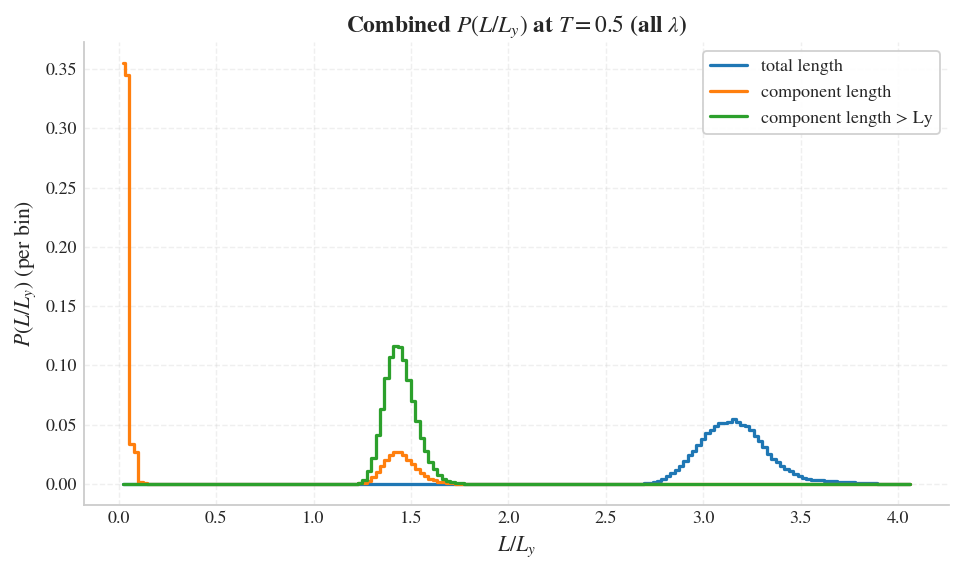

T=0.6 | total length: lambdas=41, total_count=163959
T=0.6 | component length: lambdas=41, total_count=3552479
T=0.6 | component length > Ly: lambdas=41, total_count=327918
Saved ../results/analysis/summary_plots/combined_normalized_distributions/combined_normalized_distribution_T_0.600000.png


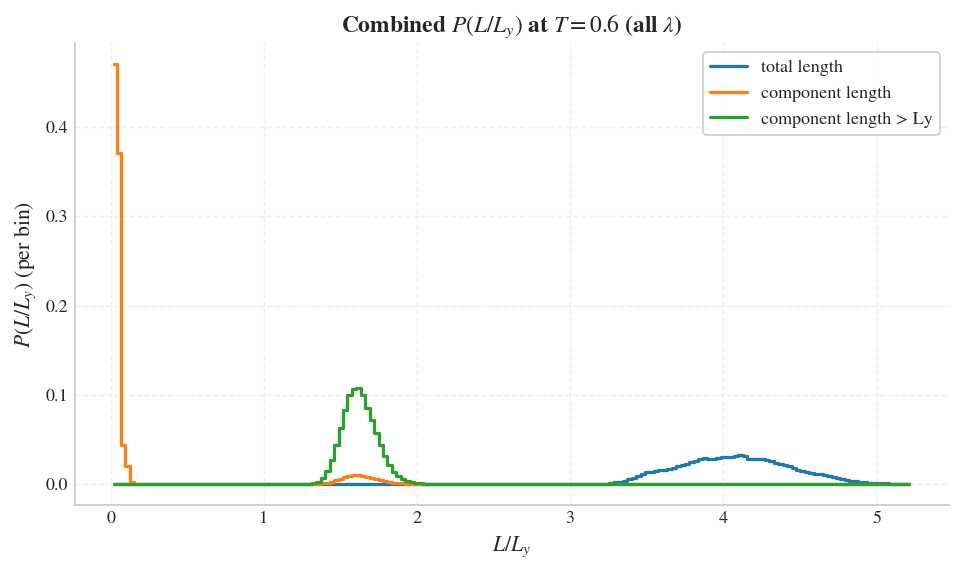

T=0.7 | total length: lambdas=41, total_count=163959
T=0.7 | component length: lambdas=41, total_count=7886233
T=0.7 | component length > Ly: lambdas=41, total_count=327918
Saved ../results/analysis/summary_plots/combined_normalized_distributions/combined_normalized_distribution_T_0.700000.png


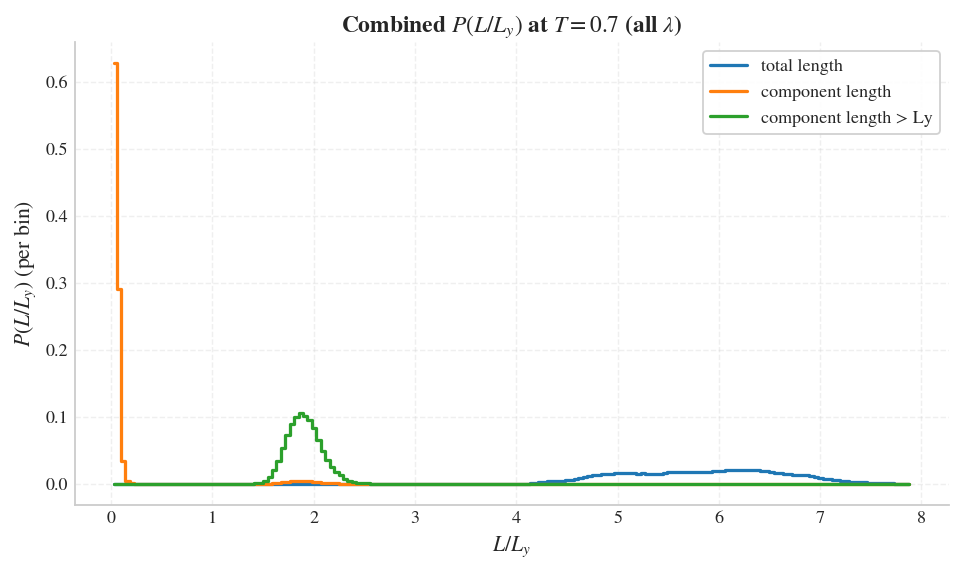

T=0.8 | total length: lambdas=41, total_count=163959
T=0.8 | component length: lambdas=41, total_count=13735856
T=0.8 | component length > Ly: lambdas=41, total_count=327918
Saved ../results/analysis/summary_plots/combined_normalized_distributions/combined_normalized_distribution_T_0.800000.png


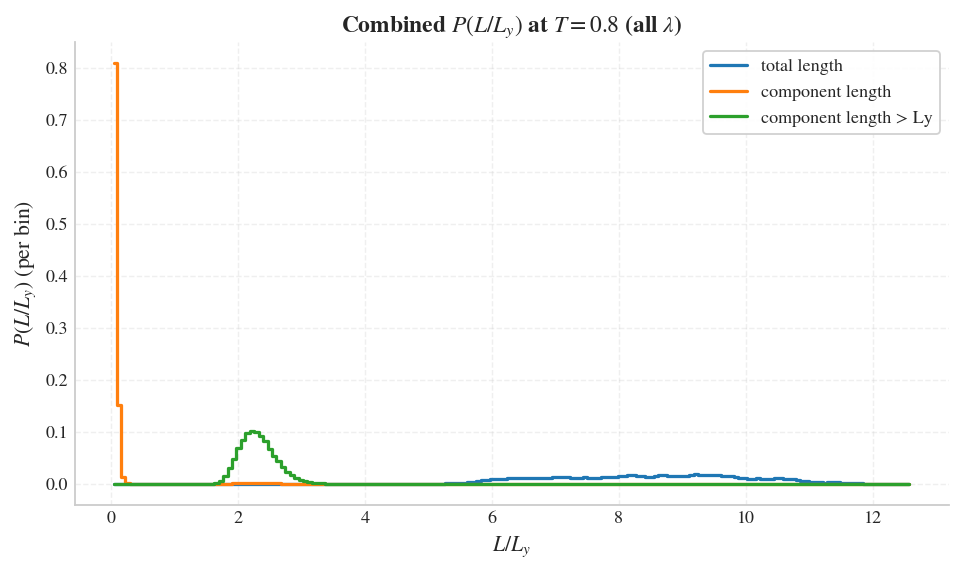

T=0.9 | total length: lambdas=41, total_count=163959
T=0.9 | component length: lambdas=41, total_count=21569301
T=0.9 | component length > Ly: lambdas=41, total_count=327918
Saved ../results/analysis/summary_plots/combined_normalized_distributions/combined_normalized_distribution_T_0.900000.png


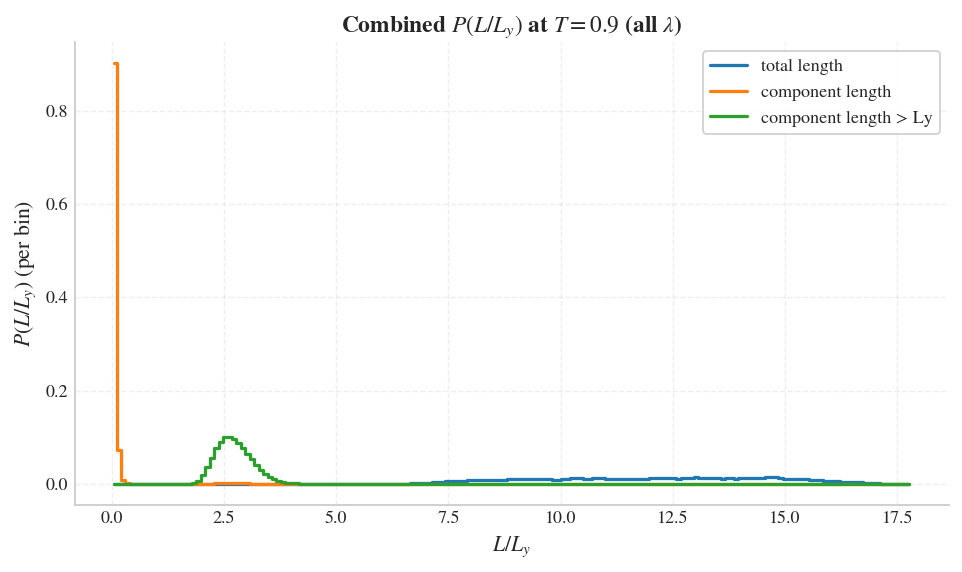

T=1 | total length: lambdas=41, total_count=163959
T=1 | component length: lambdas=41, total_count=28444477
T=1 | component length > Ly: lambdas=41, total_count=327984
Saved ../results/analysis/summary_plots/combined_normalized_distributions/combined_normalized_distribution_T_1.000000.png


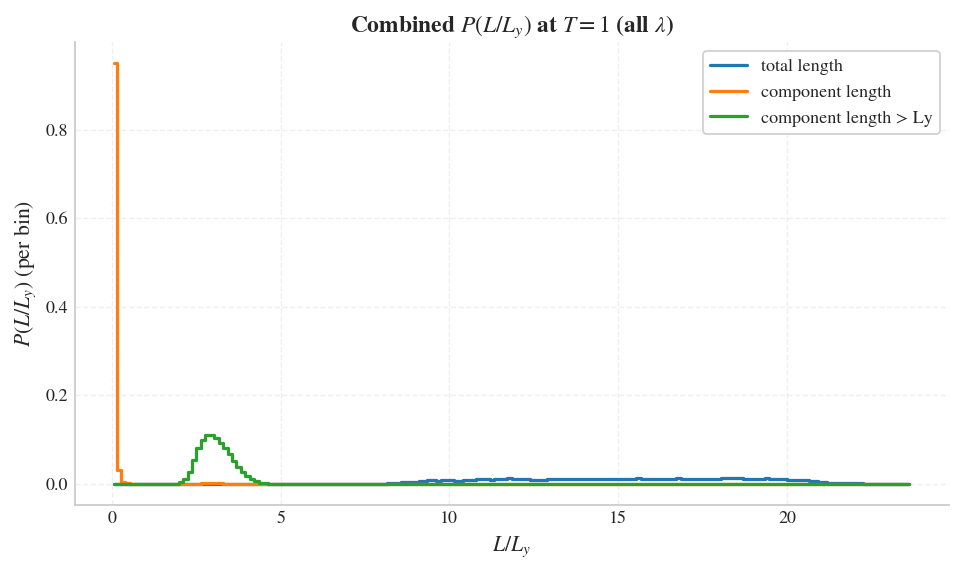

[overlay] P(L/Ly) compare T=0.5 vs T=0.7
Saved ../results/analysis/summary_plots/combined_normalized_distributions/combined_normalized_distribution_overlay_total_length_T_0.500000_vs_T_0.700000.png


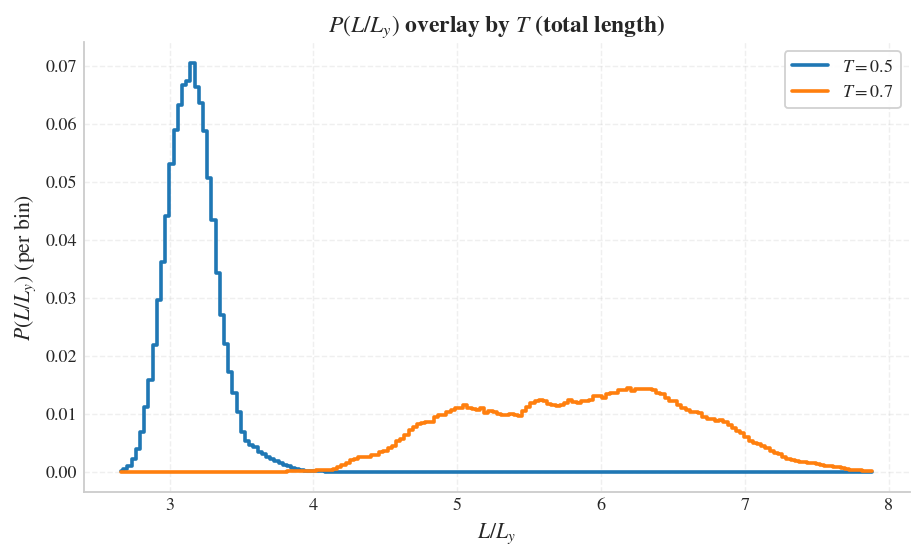

Saved ../results/analysis/summary_plots/combined_normalized_distributions/combined_normalized_distribution_overlay_component_length_T_0.500000_vs_T_0.700000.png


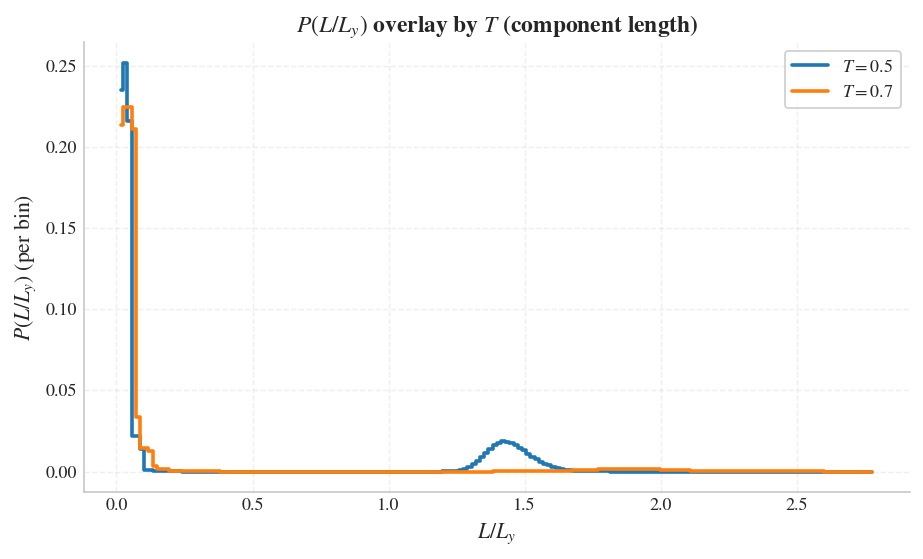

Saved ../results/analysis/summary_plots/combined_normalized_distributions/combined_normalized_distribution_overlay_component_length_gt_ly_T_0.500000_vs_T_0.700000.png


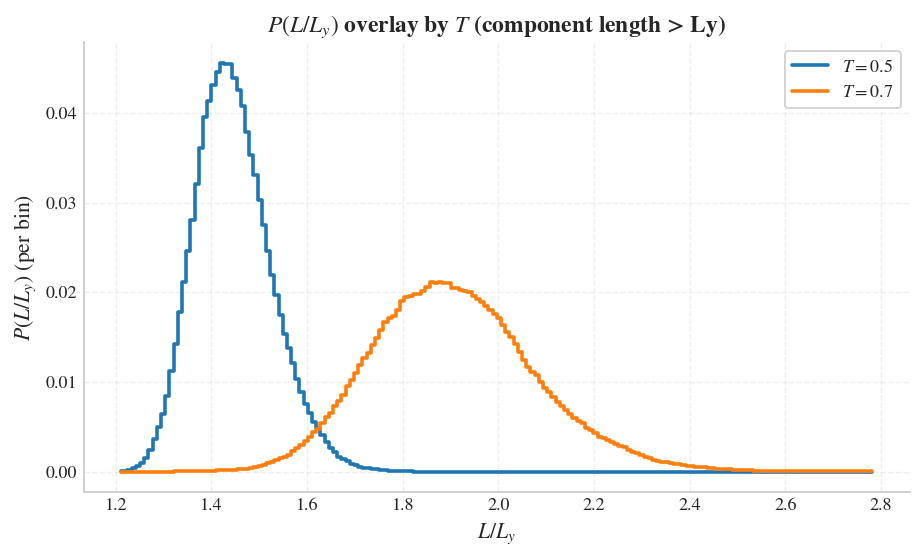

In [2]:
# --- Combined normalized distributions (all lambda) for each T ---
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "apply_plot_style" not in globals():
    def apply_plot_style():
        plt.style.use("seaborn-v0_8-whitegrid")
        plt.rcParams.update({
            "figure.dpi": 130,
            "savefig.dpi": 300,
            "axes.titlesize": 13,
            "axes.titleweight": "semibold",
            "axes.labelsize": 12,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "grid.alpha": 0.28,
            "grid.linestyle": "--",
            "legend.frameon": True,
            "legend.framealpha": 0.9,
            "legend.fancybox": True,
            "legend.edgecolor": "0.8",
            "mathtext.fontset": "stix",
            "font.family": "STIXGeneral",
        })

apply_plot_style()


if "base_dir" in globals():
    dist_base_dir = Path(base_dir)
else:
    candidates = [Path("../results") / "analysis", Path("results") / "analysis"]
    dist_base_dir = next((p for p in candidates if p.exists()), candidates[0])

if not dist_base_dir.exists():
    raise RuntimeError(f"Results directory not found: {dist_base_dir}")

if "lambda_key" not in globals():
    def lambda_key(val):
        return round(float(val), 6)

if "load_ly_map" not in globals():
    ly_file_candidates_local = [
        "summary_Ly.csv",
        "summary_ly.csv",
        "summary_Ly_mean.csv",
        "summary.csv",
    ]

    if "orig_base_dir" not in globals():
        orig_base_dir = Path('/home/bh692/scratch_pi_co54/bh692/results/20260113_test_area_with_num_tri_types')

    def find_orig_analysis_dir(t_val: float):
        name_candidates = [
            f"T_{t_val:g}_analysis",
            f"T_{t_val:.1f}_analysis",
            f"T_{t_val:.2f}_analysis",
        ]

        fallback = None
        for name in name_candidates:
            path = orig_base_dir / name
            if not path.exists():
                continue
            if fallback is None:
                fallback = path
            if (path / "data_analysis" / "summary_partial_U_lambda.csv").exists():
                return path

        if fallback is not None:
            # If none of the direct candidates has the summary CSV, still keep this as a fallback.
            # load_ly_map will perform an additional recursive CSV search in this directory.
            return fallback

        # Last fallback: match numerically against any T_*_analysis directory.
        for path in sorted(orig_base_dir.glob("T_*_analysis")):
            token = path.name[len("T_"):-len("_analysis")]
            try:
                if abs(float(token) - t_val) < 1e-8:
                    return path
            except Exception:
                continue

        return None

    def load_ly_map(t_val: float, t_dir: Path):
        for name in ly_file_candidates_local:
            path = t_dir / name
            if not path.exists():
                continue
            df = pd.read_csv(path)
            if "lambda" not in df.columns:
                continue
            for col in ("Ly_mean", "Ly", "ly_mean", "ly"):
                if col in df.columns:
                    return {lambda_key(lam): float(ly) for lam, ly in zip(df["lambda"], df[col])}

        if orig_base_dir.exists():
            orig_dir = find_orig_analysis_dir(t_val)
            if orig_dir is not None:
                csv_candidates = [
                    orig_dir / "data_analysis" / "summary_partial_U_lambda.csv",
                    orig_dir / "summary_partial_U_lambda.csv",
                ]
                csv_path = next((p for p in csv_candidates if p.exists()), None)
                if csv_path is None:
                    matches = sorted(orig_dir.glob("**/summary_partial_U_lambda.csv"))
                    if matches:
                        csv_path = matches[0]

                if csv_path is not None:
                    df = pd.read_csv(csv_path)
                    if "lambda_deform" in df.columns and "Ly_mean" in df.columns:
                        return {
                            lambda_key(lam): float(ly)
                            for lam, ly in zip(df["lambda_deform"], df["Ly_mean"])
                        }

        return {}

hist_method_specs = [
    ("total length", "ab_network_total_length_hist.csv"),
    ("component length", "ab_network_component_length_hist.csv"),
    ("component length > Ly", "ab_network_component_length_gt_Ly_hist.csv"),
]


def rebin_intervals(intervals, edges):
    rebinned = np.zeros(len(edges) - 1, dtype=float)
    for left, right, weight in intervals:
        if not np.isfinite(left) or not np.isfinite(right) or not np.isfinite(weight):
            continue
        if weight <= 0 or right <= left:
            continue

        start = max(0, np.searchsorted(edges, left, side="right") - 1)
        stop = min(len(edges) - 2, np.searchsorted(edges, right, side="left"))
        for i in range(start, stop + 1):
            lo = max(left, edges[i])
            hi = min(right, edges[i + 1])
            if hi > lo:
                rebinned[i] += weight * (hi - lo) / (right - left)
    return rebinned


intervals_by_T = {}
lambda_used = {}
missing_ly_pairs = set()

for t_dir in sorted(dist_base_dir.glob("T_*")):
    if not t_dir.is_dir():
        continue

    try:
        t_val = float(t_dir.name.split("T_")[1])
    except Exception:
        continue

    ly_map = load_ly_map(t_val, t_dir)

    for lambda_dir in sorted(t_dir.glob("lambda_*")):
        if not lambda_dir.is_dir():
            continue

        try:
            lam_val = float(lambda_dir.name.split("lambda_")[1])
        except Exception:
            continue

        ly_val = ly_map.get(lambda_key(lam_val))
        if ly_val is None or (not np.isfinite(ly_val)) or ly_val <= 0:
            missing_ly_pairs.add((t_val, lam_val))
            continue

        for label, hist_name in hist_method_specs:
            hist_path = lambda_dir / hist_name
            if not hist_path.exists():
                continue

            df = pd.read_csv(hist_path)
            required_cols = {"bin_left", "bin_right", "count"}
            if not required_cols.issubset(df.columns):
                print(f"[skip] {hist_path} missing required columns {required_cols}")
                continue

            left = df["bin_left"].to_numpy(dtype=float) / ly_val
            right = df["bin_right"].to_numpy(dtype=float) / ly_val
            count = df["count"].to_numpy(dtype=float)

            valid = np.isfinite(left) & np.isfinite(right) & np.isfinite(count) & (count > 0) & (right > left)
            if not np.any(valid):
                continue

            intervals_by_T.setdefault(t_val, {}).setdefault(label, []).extend(
                zip(left[valid], right[valid], count[valid])
            )
            lambda_used.setdefault(t_val, {}).setdefault(label, set()).add(lam_val)

if not intervals_by_T:
    raise RuntimeError("No histogram data found under results/analysis/T_*/lambda_*/ab_network_*_hist.csv")

if missing_ly_pairs:
    print(f"Skipped {len(missing_ly_pairs)} (T, lambda) pairs due to missing Ly.")

combined_out_dir = dist_base_dir / "summary_plots" / "combined_normalized_distributions"
combined_out_dir.mkdir(parents=True, exist_ok=True)

n_bins = 180

for t_val in sorted(intervals_by_T.keys()):
    method_map = intervals_by_T[t_val]

    spans = []
    for label, _ in hist_method_specs:
        intervals = method_map.get(label, [])
        if intervals:
            spans.append((min(x[0] for x in intervals), max(x[1] for x in intervals)))

    if not spans:
        continue

    x_min = min(s[0] for s in spans)
    x_max = max(s[1] for s in spans)
    if (not np.isfinite(x_min)) or (not np.isfinite(x_max)) or x_max <= x_min:
        continue

    edges = np.linspace(x_min, x_max, n_bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])

    fig, ax = plt.subplots(figsize=(7.5, 4.5))

    for label, _ in hist_method_specs:
        intervals = method_map.get(label, [])
        if not intervals:
            continue

        rebinned = rebin_intervals(intervals, edges)
        total = rebinned.sum()
        if total <= 0:
            continue

        prob = rebinned / total
        ax.step(centers, prob, where="mid", linewidth=1.8, label=label)

        n_lambda = len(lambda_used.get(t_val, {}).get(label, set()))
        print(f"T={t_val:g} | {label}: lambdas={n_lambda}, total_count={total:.0f}")

    ax.set_title(rf'Combined $P(L/L_y)$ at $T={t_val:g}$ (all $\lambda$)')
    ax.set_xlabel(r'$L/L_y$')
    ax.set_ylabel(r'$P(L/L_y)$ (per bin)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
    fig.tight_layout()

    out_path = combined_out_dir / f"combined_normalized_distribution_T_{t_val:.6f}.png"
    fig.savefig(out_path, dpi=300)
    print(f"Saved {out_path}")
    plt.show()

# --- Overlay plot across temperatures (2 Ts) for each method ---
overlay_t_values = [0.5, 0.7]  # e.g. [0.5, 1.0]; None uses lowest and highest available T.

available_t_vals = sorted(intervals_by_T.keys())
if len(available_t_vals) < 2:
    print('[overlay] Need at least two temperatures; skipping overlay plots for P(L/Ly).')
else:
    def resolve_t_values(available, requested):
        if requested is None:
            return [available[0], available[-1]]
        resolved = []
        for req in requested:
            nearest = min(available, key=lambda t: abs(t - float(req)))
            if nearest not in resolved:
                resolved.append(nearest)
        return resolved[:2]

    def method_slug(label):
        return (
            label.lower()
            .replace(' ', '_')
            .replace('>', 'gt')
            .replace('<', 'lt')
            .replace('/', '_')
        )

    t_compare = resolve_t_values(available_t_vals, overlay_t_values)
    if len(t_compare) < 2:
        print('[overlay] Could not resolve two distinct temperatures; skipping overlay plots for P(L/Ly).')
    else:
        print(f'[overlay] P(L/Ly) compare T={t_compare[0]:g} vs T={t_compare[1]:g}')
        for label, _ in hist_method_specs:
            spans = []
            for t_val in t_compare:
                intervals = intervals_by_T.get(t_val, {}).get(label, [])
                if intervals:
                    spans.append((min(x[0] for x in intervals), max(x[1] for x in intervals)))

            if not spans:
                continue

            x_min = min(s[0] for s in spans)
            x_max = max(s[1] for s in spans)
            if (not np.isfinite(x_min)) or (not np.isfinite(x_max)) or x_max <= x_min:
                continue

            edges = np.linspace(x_min, x_max, n_bins + 1)
            centers = 0.5 * (edges[:-1] + edges[1:])

            fig, ax = plt.subplots(figsize=(7.2, 4.4))
            plotted = 0

            for t_val in t_compare:
                intervals = intervals_by_T.get(t_val, {}).get(label, [])
                if not intervals:
                    continue

                rebinned = rebin_intervals(intervals, edges)
                total = float(rebinned.sum())
                if total <= 0:
                    continue

                prob = rebinned / total
                ax.step(centers, prob, where='mid', linewidth=2.0, label=rf'$T={t_val:g}$')
                plotted += 1

            if plotted == 0:
                plt.close(fig)
                continue

            ax.set_title(rf'$P(L/L_y)$ overlay by $T$ ({label})')
            ax.set_xlabel(r'$L/L_y$')
            ax.set_ylabel(r'$P(L/L_y)$ (per bin)')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='best')
            fig.tight_layout()

            out_path = combined_out_dir / (
                f'combined_normalized_distribution_overlay_{method_slug(label)}_'
                f'T_{t_compare[0]:.6f}_vs_T_{t_compare[1]:.6f}.png'
            )
            fig.savefig(out_path, dpi=300)
            print(f'Saved {out_path}')
            plt.show()


T=0.5 | total length: lambdas=41, total_count=163959
T=0.5 | component length: lambdas=41, total_count=1384859
T=0.5 | component length > Ly: lambdas=41, total_count=327918
Saved ../results/analysis/summary_plots/combined_y_distributions/combined_distribution_Y_T_0.500000.png


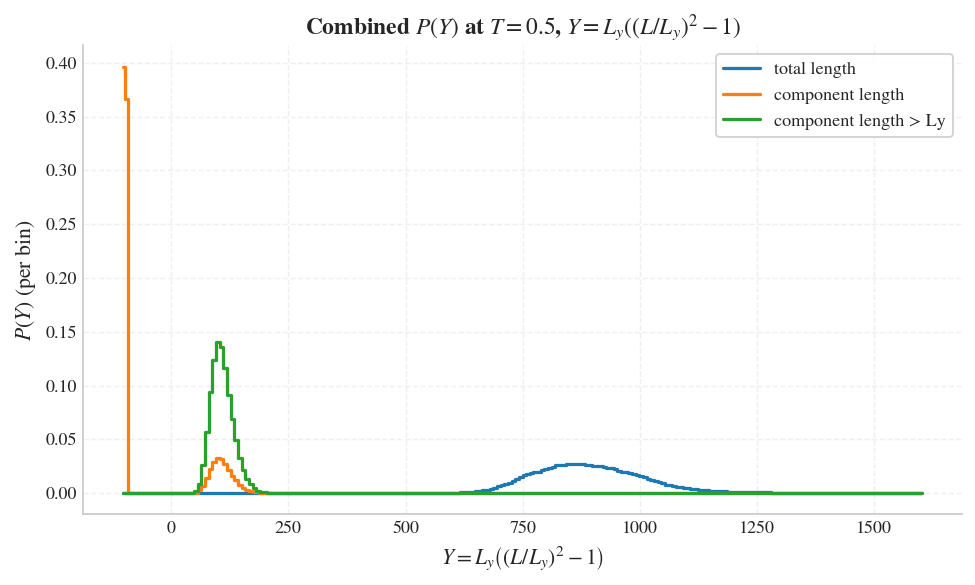

T=0.6 | total length: lambdas=41, total_count=163959
T=0.6 | component length: lambdas=41, total_count=3552479
T=0.6 | component length > Ly: lambdas=41, total_count=327918
Saved ../results/analysis/summary_plots/combined_y_distributions/combined_distribution_Y_T_0.600000.png


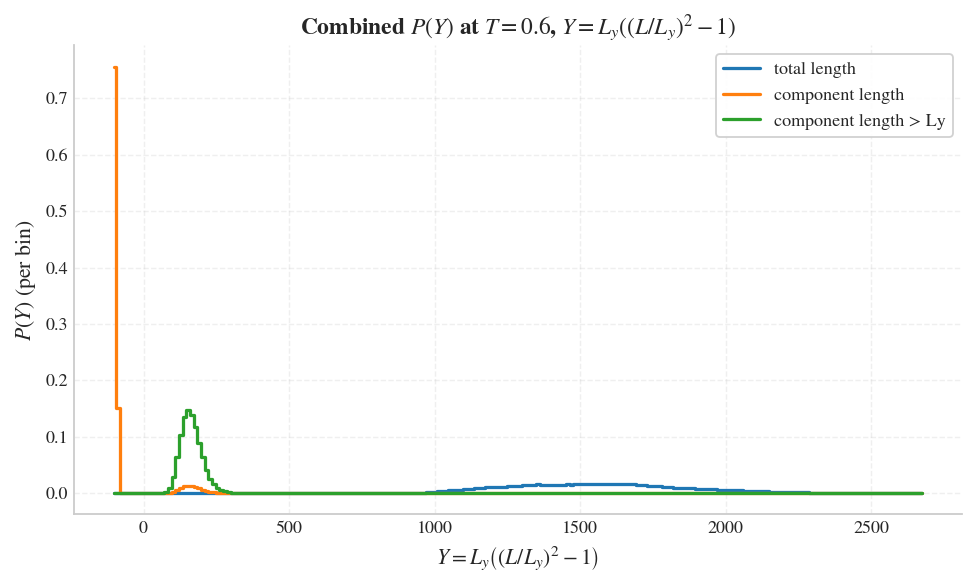

T=0.7 | total length: lambdas=41, total_count=163959
T=0.7 | component length: lambdas=41, total_count=7886233
T=0.7 | component length > Ly: lambdas=41, total_count=327918
Saved ../results/analysis/summary_plots/combined_y_distributions/combined_distribution_Y_T_0.700000.png


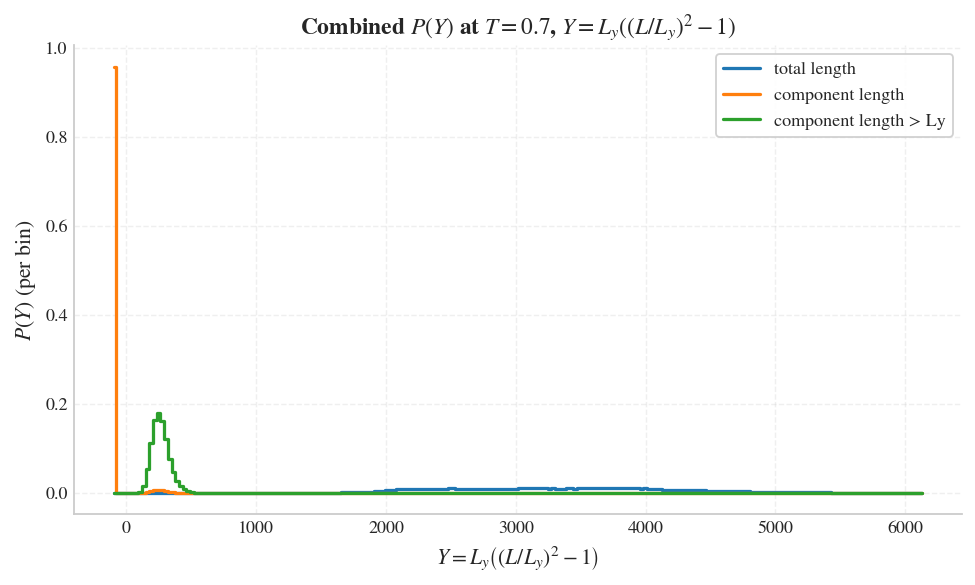

T=0.8 | total length: lambdas=41, total_count=163959
T=0.8 | component length: lambdas=41, total_count=13735856
T=0.8 | component length > Ly: lambdas=41, total_count=327918
Saved ../results/analysis/summary_plots/combined_y_distributions/combined_distribution_Y_T_0.800000.png


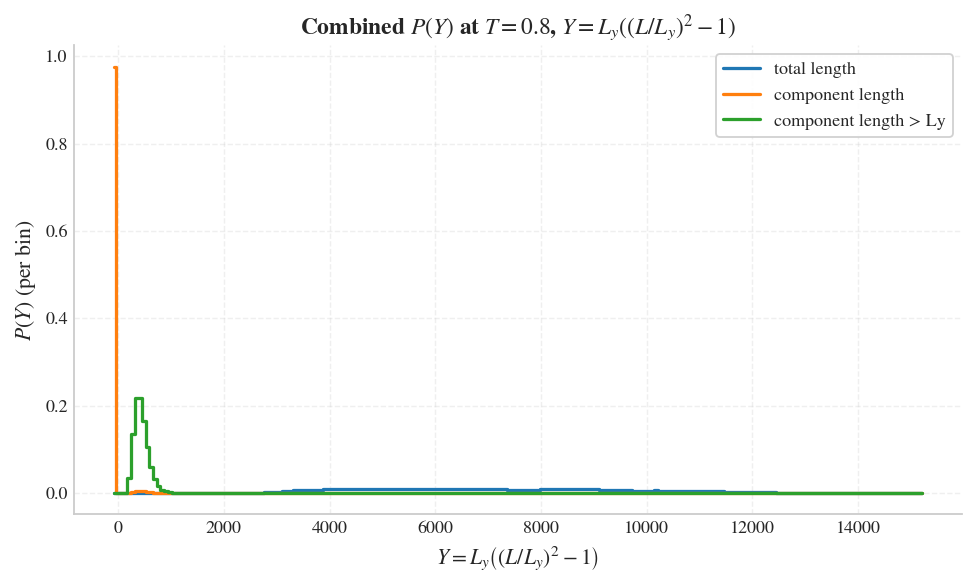

T=0.9 | total length: lambdas=41, total_count=163959
T=0.9 | component length: lambdas=41, total_count=21569301
T=0.9 | component length > Ly: lambdas=41, total_count=327918
Saved ../results/analysis/summary_plots/combined_y_distributions/combined_distribution_Y_T_0.900000.png


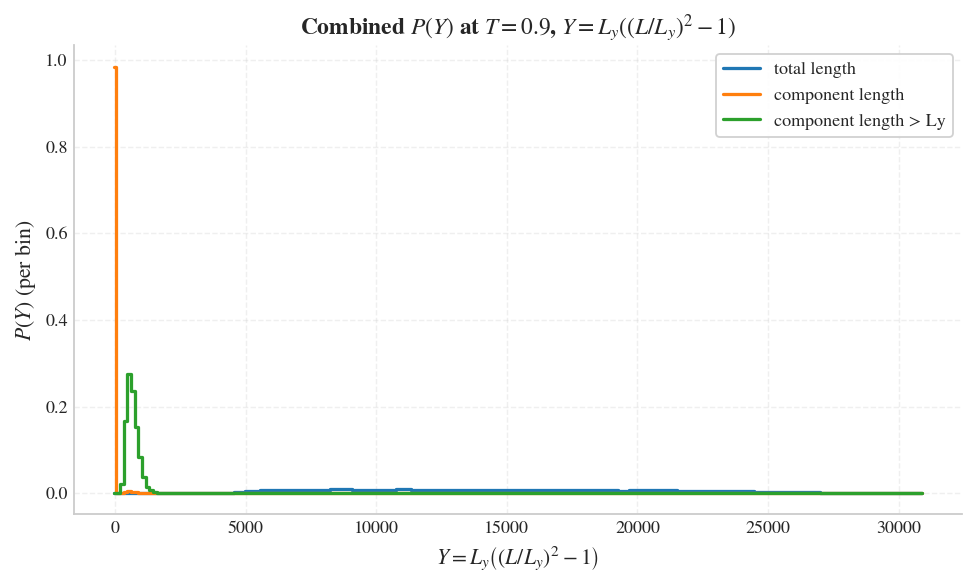

T=1 | total length: lambdas=41, total_count=163959
T=1 | component length: lambdas=41, total_count=28444477
T=1 | component length > Ly: lambdas=41, total_count=327984
Saved ../results/analysis/summary_plots/combined_y_distributions/combined_distribution_Y_T_1.000000.png


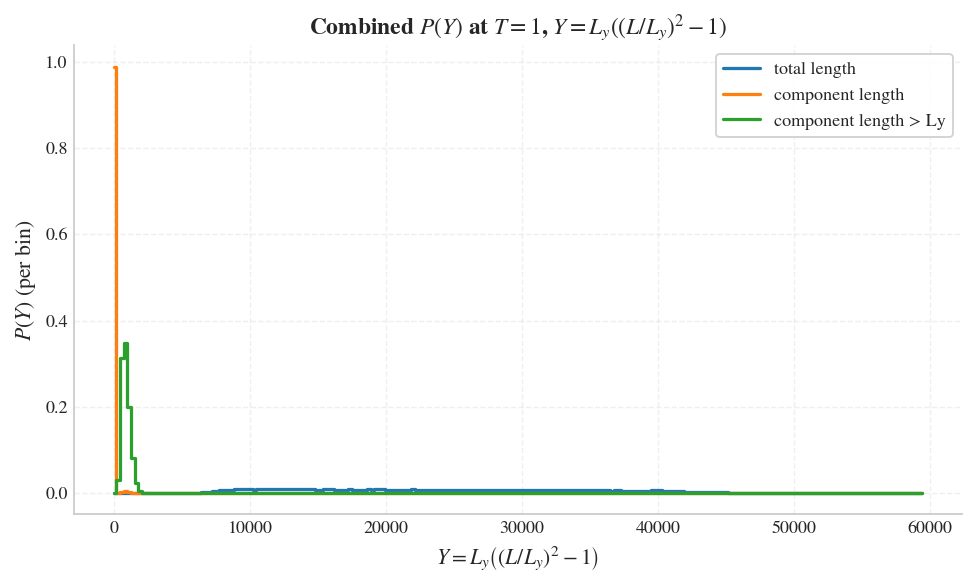

Saved ../results/analysis/summary_plots/combined_y_distributions/combined_distribution_Y_all_T.csv
[overlay] P(Y) compare T=0.5 vs T=0.7
Saved ../results/analysis/summary_plots/combined_y_distributions/combined_distribution_Y_overlay_total_length_T_0.500000_vs_T_0.700000.png


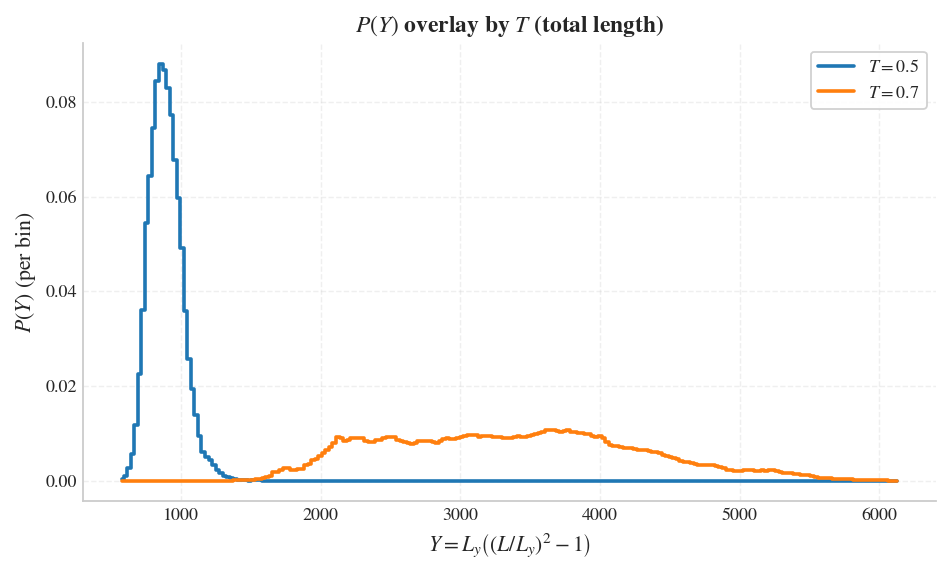

Saved ../results/analysis/summary_plots/combined_y_distributions/combined_distribution_Y_overlay_component_length_T_0.500000_vs_T_0.700000.png


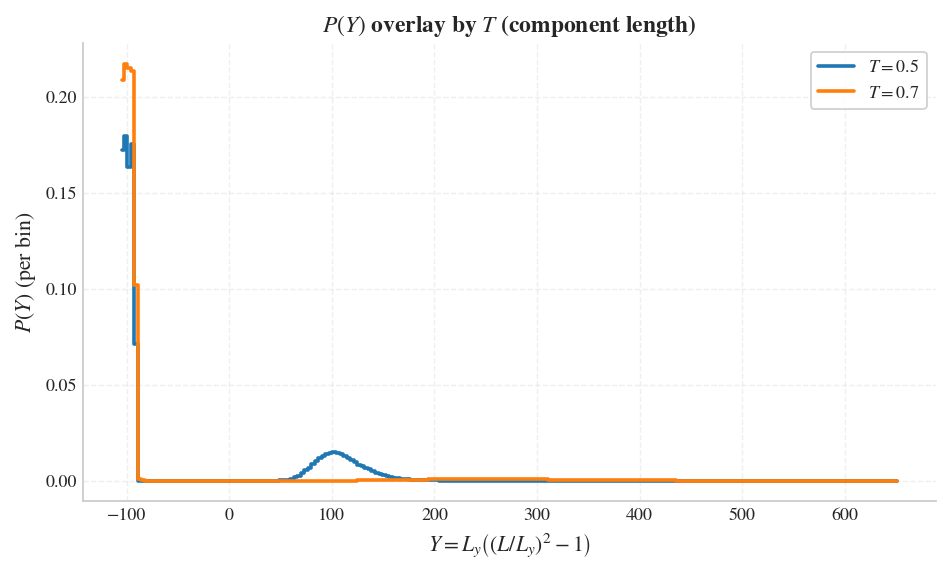

Saved ../results/analysis/summary_plots/combined_y_distributions/combined_distribution_Y_overlay_component_length_gt_ly_T_0.500000_vs_T_0.700000.png


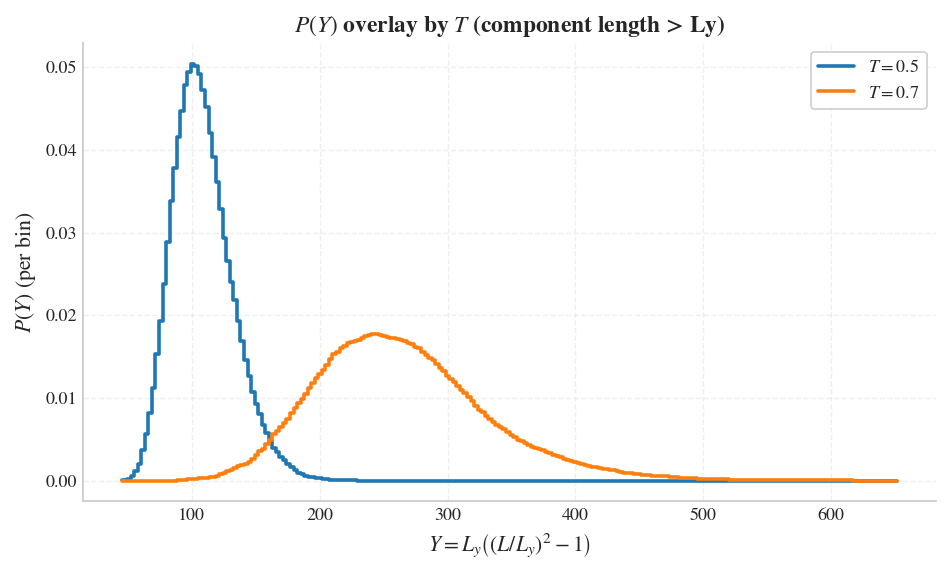

In [3]:
# --- Combined distributions of Y = Ly * (L^2 / Ly^2 - 1) for each T ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "apply_plot_style" not in globals():
    def apply_plot_style():
        plt.style.use("seaborn-v0_8-whitegrid")
        plt.rcParams.update({
            "figure.dpi": 130,
            "savefig.dpi": 300,
            "axes.titlesize": 13,
            "axes.titleweight": "semibold",
            "axes.labelsize": 12,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "grid.alpha": 0.28,
            "grid.linestyle": "--",
            "legend.frameon": True,
            "legend.framealpha": 0.9,
            "legend.fancybox": True,
            "legend.edgecolor": "0.8",
            "mathtext.fontset": "stix",
            "font.family": "STIXGeneral",
        })

apply_plot_style()

from pathlib import Path

if "dist_base_dir" not in globals() or "hist_method_specs" not in globals():
    raise RuntimeError("Run the second cell first to define dist_base_dir and hist_method_specs.")

if "lambda_key" not in globals() or "load_ly_map" not in globals():
    raise RuntimeError("Run the second cell first to define lambda_key and load_ly_map.")

if "rebin_intervals" not in globals():
    def rebin_intervals(intervals, edges):
        rebinned = np.zeros(len(edges) - 1, dtype=float)
        for left, right, weight in intervals:
            if not np.isfinite(left) or not np.isfinite(right) or not np.isfinite(weight):
                continue
            if weight <= 0 or right <= left:
                continue

            start = max(0, np.searchsorted(edges, left, side="right") - 1)
            stop = min(len(edges) - 2, np.searchsorted(edges, right, side="left"))
            for i in range(start, stop + 1):
                lo = max(left, edges[i])
                hi = min(right, edges[i + 1])
                if hi > lo:
                    rebinned[i] += weight * (hi - lo) / (right - left)
        return rebinned


def y_of_l(l_val, ly_val):
    return ly_val * ((l_val / ly_val) ** 2 - 1.0)


# Split each original L-bin into small L-subsegments to better approximate the nonlinear transform L -> Y.
n_subsegments = 24
n_bins_y = 220

intervals_y_by_T = {}
lambda_used_y = {}
missing_ly_pairs = set()

for t_dir in sorted(dist_base_dir.glob("T_*")):
    if not t_dir.is_dir():
        continue

    try:
        t_val = float(t_dir.name.split("T_")[1])
    except Exception:
        continue

    ly_map = load_ly_map(t_val, t_dir)

    for lambda_dir in sorted(t_dir.glob("lambda_*")):
        if not lambda_dir.is_dir():
            continue

        try:
            lam_val = float(lambda_dir.name.split("lambda_")[1])
        except Exception:
            continue

        ly_val = ly_map.get(lambda_key(lam_val))
        if ly_val is None or (not np.isfinite(ly_val)) or ly_val <= 0:
            missing_ly_pairs.add((t_val, lam_val))
            continue

        for label, hist_name in hist_method_specs:
            hist_path = lambda_dir / hist_name
            if not hist_path.exists():
                continue

            df = pd.read_csv(hist_path)
            required_cols = {"bin_left", "bin_right", "count"}
            if not required_cols.issubset(df.columns):
                print(f"[skip] {hist_path} missing required columns {required_cols}")
                continue

            left = df["bin_left"].to_numpy(dtype=float)
            right = df["bin_right"].to_numpy(dtype=float)
            count = df["count"].to_numpy(dtype=float)

            valid = np.isfinite(left) & np.isfinite(right) & np.isfinite(count) & (count > 0) & (right > left)
            if not np.any(valid):
                continue

            for l0, l1, c in zip(left[valid], right[valid], count[valid]):
                l_edges = np.linspace(l0, l1, n_subsegments + 1)
                w = c / n_subsegments
                for a, b in zip(l_edges[:-1], l_edges[1:]):
                    y0 = y_of_l(a, ly_val)
                    y1 = y_of_l(b, ly_val)
                    if (not np.isfinite(y0)) or (not np.isfinite(y1)):
                        continue
                    lo = min(y0, y1)
                    hi = max(y0, y1)
                    if hi <= lo:
                        continue
                    intervals_y_by_T.setdefault(t_val, {}).setdefault(label, []).append((lo, hi, w))

            lambda_used_y.setdefault(t_val, {}).setdefault(label, set()).add(lam_val)

if not intervals_y_by_T:
    raise RuntimeError("No transformed Y-histogram data could be constructed.")

if missing_ly_pairs:
    print(f"Skipped {len(missing_ly_pairs)} (T, lambda) pairs due to missing Ly.")

out_dir = dist_base_dir / "summary_plots" / "combined_y_distributions"
out_dir.mkdir(parents=True, exist_ok=True)

rows = []
for t_val in sorted(intervals_y_by_T.keys()):
    method_map = intervals_y_by_T[t_val]

    spans = []
    for label, _ in hist_method_specs:
        intervals = method_map.get(label, [])
        if intervals:
            spans.append((min(x[0] for x in intervals), max(x[1] for x in intervals)))

    if not spans:
        continue

    y_min = min(s[0] for s in spans)
    y_max = max(s[1] for s in spans)
    if (not np.isfinite(y_min)) or (not np.isfinite(y_max)) or y_max <= y_min:
        continue

    edges = np.linspace(y_min, y_max, n_bins_y + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])

    fig, ax = plt.subplots(figsize=(7.6, 4.6))

    for label, _ in hist_method_specs:
        intervals = method_map.get(label, [])
        if not intervals:
            continue

        rebinned = rebin_intervals(intervals, edges)
        total = float(rebinned.sum())
        if total <= 0:
            continue

        prob = rebinned / total
        ax.step(centers, prob, where="mid", linewidth=1.8, label=label)

        n_lambda = len(lambda_used_y.get(t_val, {}).get(label, set()))
        print(f"T={t_val:g} | {label}: lambdas={n_lambda}, total_count={total:.0f}")

        for y_val, p_val in zip(centers, prob):
            rows.append({"T": t_val, "method": label, "Y_center": float(y_val), "probability": float(p_val)})

    ax.set_title(rf'Combined $P(Y)$ at $T={t_val:g}$, $Y=L_y((L/L_y)^2-1)$')
    ax.set_xlabel(r'$Y = L_y\left((L/L_y)^2 - 1\right)$')
    ax.set_ylabel(r'$P(Y)$ (per bin)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
    fig.tight_layout()

    out_path = out_dir / f"combined_distribution_Y_T_{t_val:.6f}.png"
    fig.savefig(out_path, dpi=300)
    print(f"Saved {out_path}")
    plt.show()

if rows:
    df = pd.DataFrame(rows)
    out_csv = out_dir / "combined_distribution_Y_all_T.csv"
    df.to_csv(out_csv, index=False)
    print(f"Saved {out_csv}")

# --- Overlay plot across temperatures (2 Ts) for Y distributions ---
overlay_t_values_y = [0.5, 0.7]  # e.g. [0.5, 1.0]; None uses lowest and highest available T.

available_t_vals_y = sorted(intervals_y_by_T.keys())
if len(available_t_vals_y) < 2:
    print('[overlay] Need at least two temperatures; skipping overlay plots for P(Y).')
else:
    def resolve_t_values(available, requested):
        if requested is None:
            return [available[0], available[-1]]
        resolved = []
        for req in requested:
            nearest = min(available, key=lambda t: abs(t - float(req)))
            if nearest not in resolved:
                resolved.append(nearest)
        return resolved[:2]

    def method_slug(label):
        return (
            label.lower()
            .replace(' ', '_')
            .replace('>', 'gt')
            .replace('<', 'lt')
            .replace('/', '_')
        )

    t_compare = resolve_t_values(available_t_vals_y, overlay_t_values_y)
    if len(t_compare) < 2:
        print('[overlay] Could not resolve two distinct temperatures; skipping overlay plots for P(Y).')
    else:
        print(f'[overlay] P(Y) compare T={t_compare[0]:g} vs T={t_compare[1]:g}')
        for label, _ in hist_method_specs:
            spans = []
            for t_val in t_compare:
                intervals = intervals_y_by_T.get(t_val, {}).get(label, [])
                if intervals:
                    spans.append((min(x[0] for x in intervals), max(x[1] for x in intervals)))

            if not spans:
                continue

            y_min = min(s[0] for s in spans)
            y_max = max(s[1] for s in spans)
            if (not np.isfinite(y_min)) or (not np.isfinite(y_max)) or y_max <= y_min:
                continue

            edges = np.linspace(y_min, y_max, n_bins_y + 1)
            centers = 0.5 * (edges[:-1] + edges[1:])

            fig, ax = plt.subplots(figsize=(7.4, 4.5))
            plotted = 0

            for t_val in t_compare:
                intervals = intervals_y_by_T.get(t_val, {}).get(label, [])
                if not intervals:
                    continue

                rebinned = rebin_intervals(intervals, edges)
                total = float(rebinned.sum())
                if total <= 0:
                    continue

                prob = rebinned / total
                ax.step(centers, prob, where='mid', linewidth=2.0, label=rf'$T={t_val:g}$')
                plotted += 1

            if plotted == 0:
                plt.close(fig)
                continue

            ax.set_title(rf'$P(Y)$ overlay by $T$ ({label})')
            ax.set_xlabel(r'$Y = L_y\left((L/L_y)^2 - 1\right)$')
            ax.set_ylabel(r'$P(Y)$ (per bin)')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='best')
            fig.tight_layout()

            out_path = out_dir / (
                f'combined_distribution_Y_overlay_{method_slug(label)}_'
                f'T_{t_compare[0]:.6f}_vs_T_{t_compare[1]:.6f}.png'
            )
            fig.savefig(out_path, dpi=300)
            print(f'Saved {out_path}')
            plt.show()


T=0.5 | total length: slope=-0.00665, R^2=0.5058, gamma=0.00665
T=0.5 | component length: slope=-0.01552, R^2=0.1989, gamma=0.01552
T=0.5 | component length > Ly: slope=-0.02548, R^2=0.2778, gamma=0.02548
Saved ../results/analysis/summary_plots/combined_y_distributions/semilog_fit_Y_T_0.500000.png


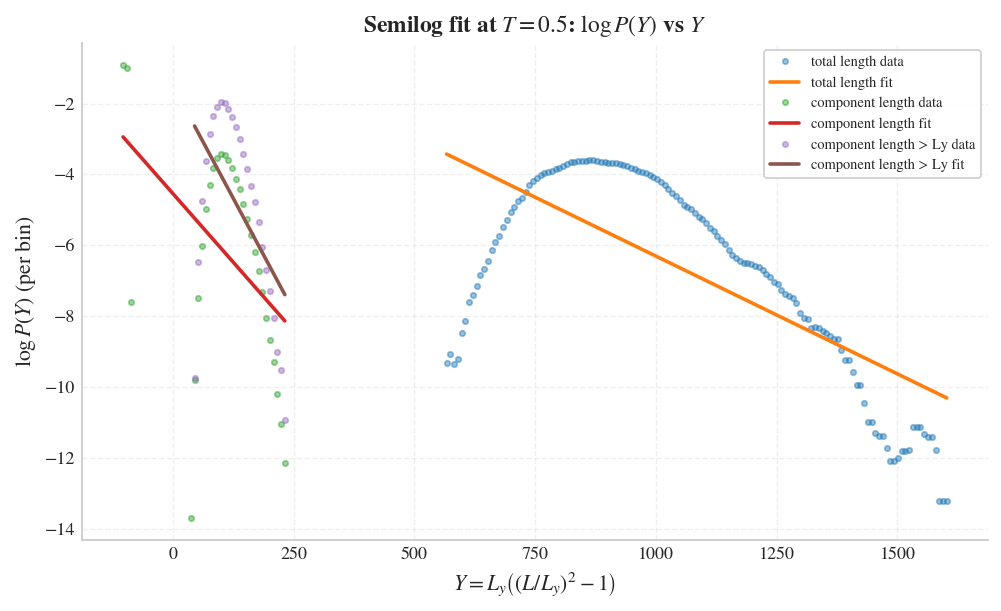

T=0.6 | total length: slope=-0.001429, R^2=0.1284, gamma=0.001715
T=0.6 | component length: slope=-0.01747, R^2=0.4011, gamma=0.02097
T=0.6 | component length > Ly: slope=-0.0199, R^2=0.4281, gamma=0.02388
Saved ../results/analysis/summary_plots/combined_y_distributions/semilog_fit_Y_T_0.600000.png


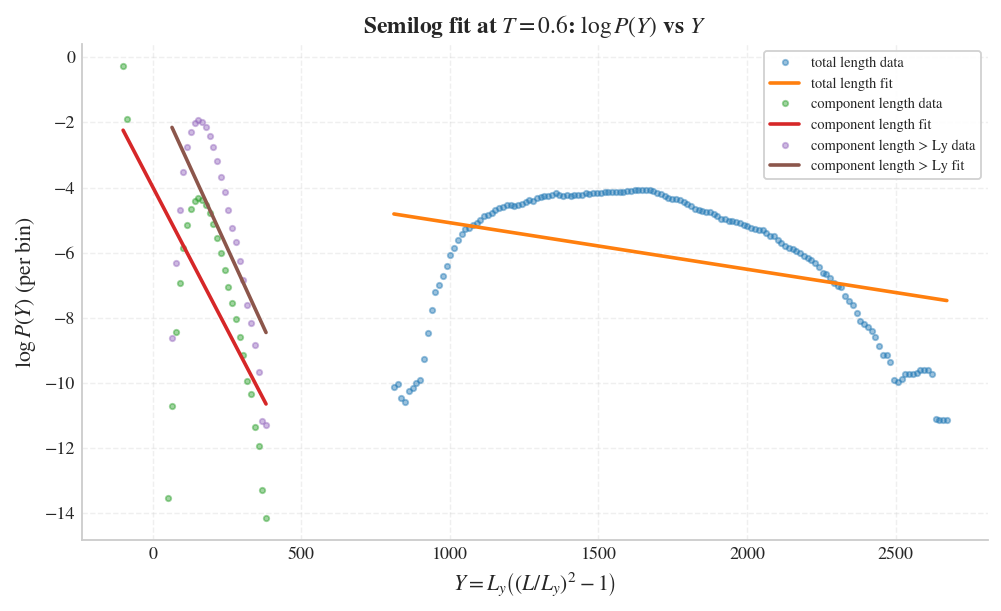

T=0.7 | total length: slope=-0.0004291, R^2=0.1390, gamma=0.0006007
T=0.7 | component length: slope=-0.006869, R^2=0.1827, gamma=0.009616
T=0.7 | component length > Ly: slope=-0.00886, R^2=0.2939, gamma=0.0124
Saved ../results/analysis/summary_plots/combined_y_distributions/semilog_fit_Y_T_0.700000.png


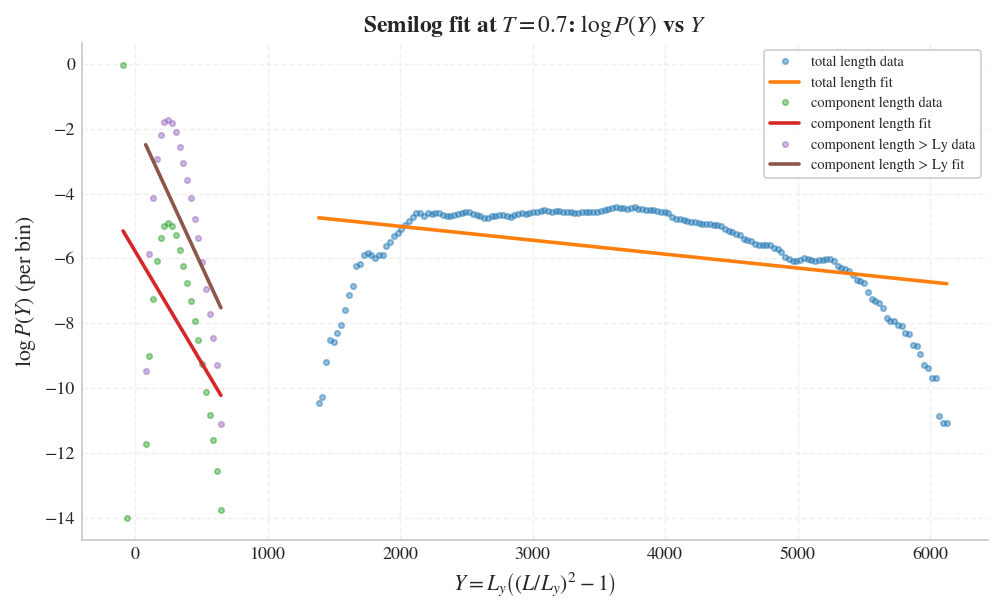

T=0.8 | total length: slope=-0.0002547, R^2=0.4393, gamma=0.0004075
T=0.8 | component length: slope=-0.004301, R^2=0.1837, gamma=0.006881
T=0.8 | component length > Ly: slope=-0.005996, R^2=0.5716, gamma=0.009594
Saved ../results/analysis/summary_plots/combined_y_distributions/semilog_fit_Y_T_0.800000.png


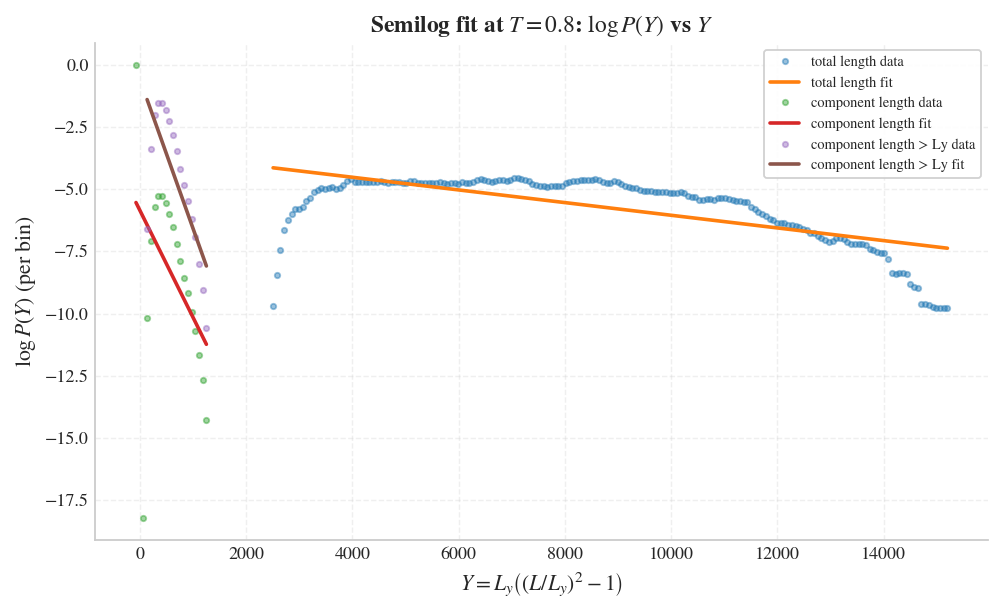

T=0.9 | total length: slope=-7.697e-05, R^2=0.3509, gamma=0.0001385
T=0.9 | component length: slope=-0.004656, R^2=0.5930, gamma=0.008381
T=0.9 | component length > Ly: slope=-0.004005, R^2=0.4953, gamma=0.007208
Saved ../results/analysis/summary_plots/combined_y_distributions/semilog_fit_Y_T_0.900000.png


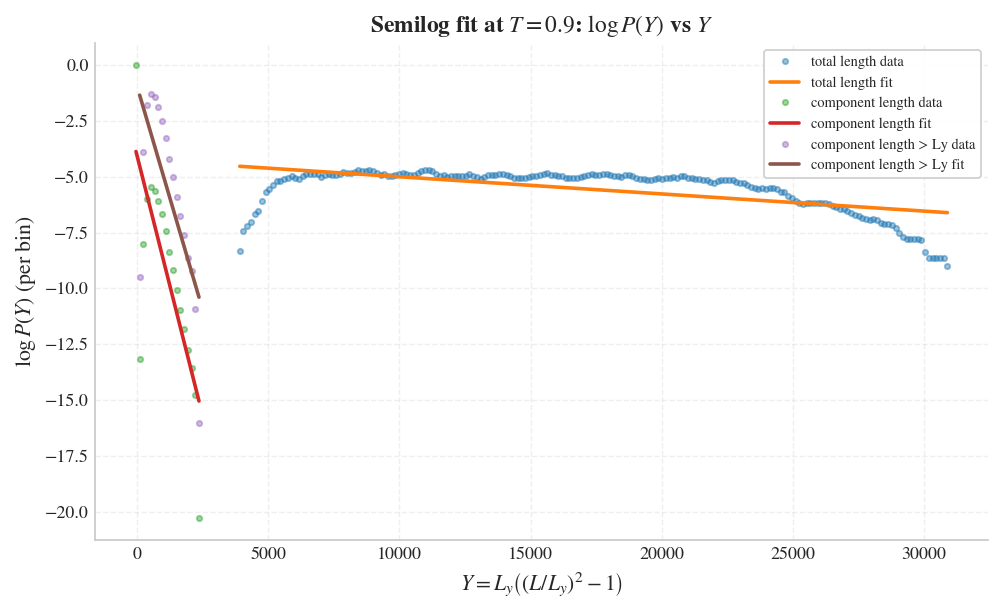

T=1 | total length: slope=-8.24e-05, R^2=0.6168, gamma=0.0001648
T=1 | component length: slope=-0.004018, R^2=0.7612, gamma=0.008035
T=1 | component length > Ly: slope=-0.001436, R^2=0.1463, gamma=0.002873
Saved ../results/analysis/summary_plots/combined_y_distributions/semilog_fit_Y_T_1.000000.png


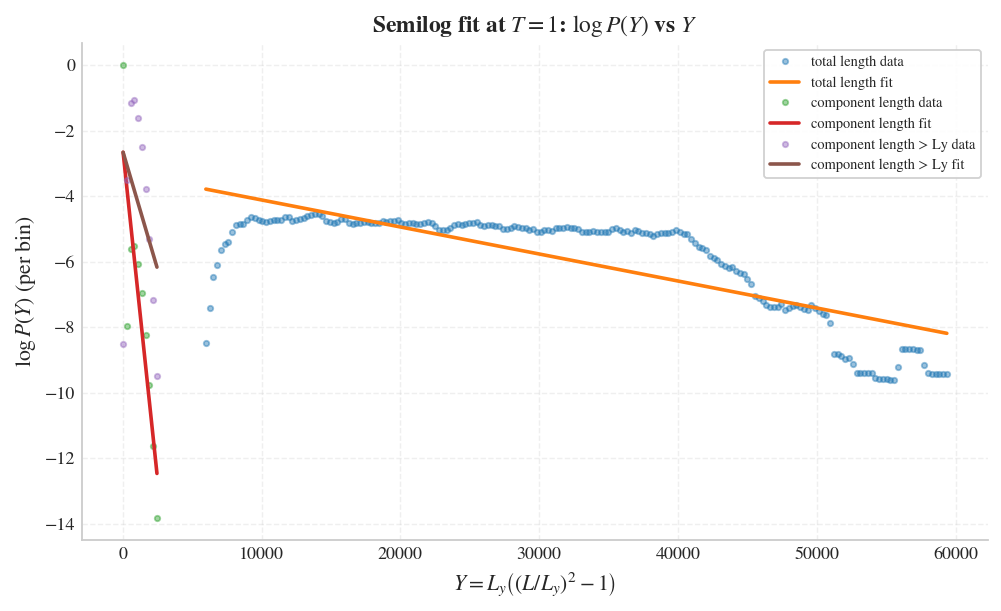

Saved ../results/analysis/summary_plots/combined_y_distributions/gamma_vs_T_from_Y_semilog_fit.csv
Saved ../results/analysis/summary_plots/combined_y_distributions/gamma_vs_T_from_Y_semilog_fit.png


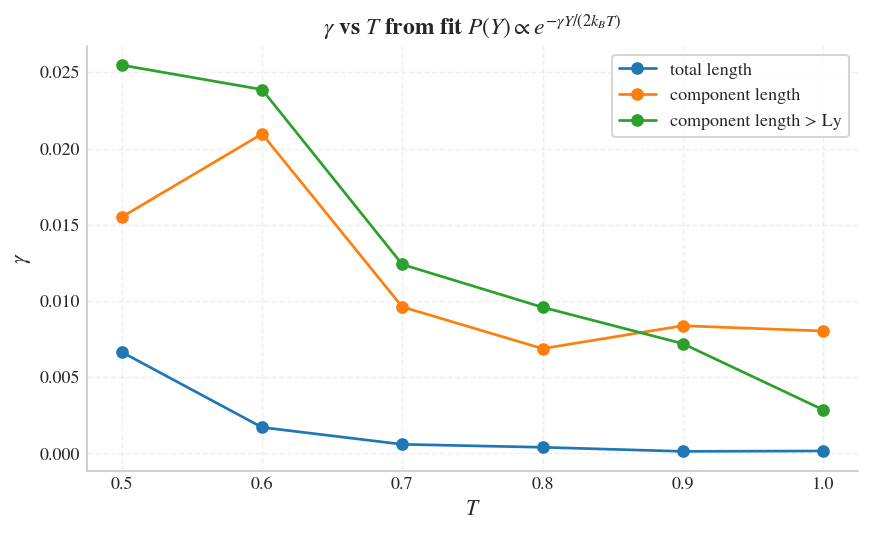

In [4]:
# --- Fit P(Y) ~ exp(-0.5 * gamma * Y / (k_B * T)) to get gamma(T), with Y=Ly*(L^2/Ly^2 - 1) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "apply_plot_style" not in globals():
    def apply_plot_style():
        plt.style.use("seaborn-v0_8-whitegrid")
        plt.rcParams.update({
            "figure.dpi": 130,
            "savefig.dpi": 300,
            "axes.titlesize": 13,
            "axes.titleweight": "semibold",
            "axes.labelsize": 12,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "grid.alpha": 0.28,
            "grid.linestyle": "--",
            "legend.frameon": True,
            "legend.framealpha": 0.9,
            "legend.fancybox": True,
            "legend.edgecolor": "0.8",
            "mathtext.fontset": "stix",
            "font.family": "STIXGeneral",
        })

apply_plot_style()


if "intervals_y_by_T" not in globals() or "hist_method_specs" not in globals() or "rebin_intervals" not in globals():
    raise RuntimeError("Run the 3rd cell first to build intervals_y_by_T, hist_method_specs, and rebin_intervals.")

if "k_B" not in globals():
    k_B = 1.0

fit_prob_floor = 0.0
fit_y_min = None   # Example: set to 0.0 to fit only Y >= 0
fit_y_max = None
min_fit_points = 10
n_bins_fit_y = n_bins_y if "n_bins_y" in globals() else 220

fit_rows = []
gamma_by_method = {label: [] for label, _ in hist_method_specs}

for t_val in sorted(intervals_y_by_T.keys()):
    method_map = intervals_y_by_T[t_val]

    spans = []
    for label, _ in hist_method_specs:
        intervals = method_map.get(label, [])
        if intervals:
            spans.append((min(x[0] for x in intervals), max(x[1] for x in intervals)))

    if not spans:
        continue

    y_min = min(s[0] for s in spans)
    y_max = max(s[1] for s in spans)
    if (not np.isfinite(y_min)) or (not np.isfinite(y_max)) or y_max <= y_min:
        continue

    edges = np.linspace(y_min, y_max, n_bins_fit_y + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])

    fig, ax = plt.subplots(figsize=(7.8, 4.8))

    for label, _ in hist_method_specs:
        intervals = method_map.get(label, [])
        if not intervals:
            continue

        rebinned = rebin_intervals(intervals, edges)
        total = float(rebinned.sum())
        if total <= 0:
            continue

        prob = rebinned / total
        mask = np.isfinite(prob) & (prob > fit_prob_floor)
        if fit_y_min is not None:
            mask &= centers >= fit_y_min
        if fit_y_max is not None:
            mask &= centers <= fit_y_max

        y_fit = centers[mask]
        logp_fit = np.log(prob[mask])

        if y_fit.size < min_fit_points:
            print(f"[skip fit] T={t_val:g} | {label}: only {y_fit.size} fit points")
            continue

        slope_stderr = np.nan
        try:
            coeffs, cov = np.polyfit(y_fit, logp_fit, 1, cov=True)
            slope = float(coeffs[0])
            intercept = float(coeffs[1])
            if np.isfinite(cov[0, 0]) and cov[0, 0] >= 0:
                slope_stderr = float(np.sqrt(cov[0, 0]))
        except Exception:
            slope, intercept = np.polyfit(y_fit, logp_fit, 1)
            slope = float(slope)
            intercept = float(intercept)

        y_hat = slope * y_fit + intercept
        ss_res = float(np.sum((logp_fit - y_hat) ** 2))
        ss_tot = float(np.sum((logp_fit - logp_fit.mean()) ** 2))
        r2 = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else np.nan

        # log P(Y) = c - [gamma/(2*k_B*T)] * Y  =>  slope = -gamma/(2*k_B*T)
        gamma_val = float(-2.0 * k_B * t_val * slope)
        gamma_stderr = float(2.0 * k_B * t_val * slope_stderr) if np.isfinite(slope_stderr) else np.nan

        fit_rows.append({
            "T": t_val,
            "method": label,
            "slope_logP_vs_Y": slope,
            "slope_stderr": slope_stderr,
            "intercept": intercept,
            "r2": r2,
            "n_fit_points": int(y_fit.size),
            "gamma": gamma_val,
            "gamma_stderr": gamma_stderr,
            "n_total": int(round(total)),
            "n_lambda": len(lambda_used_y.get(t_val, {}).get(label, set())) if "lambda_used_y" in globals() else np.nan,
        })
        gamma_by_method[label].append((t_val, gamma_val))

        positive = prob > 0
        ax.plot(centers[positive], np.log(prob[positive]), ".", alpha=0.45, label=f"{label} data")
        y_line = np.linspace(y_fit.min(), y_fit.max(), 160)
        ax.plot(y_line, slope * y_line + intercept, "-", linewidth=2.0, label=f"{label} fit")

        print(
            f"T={t_val:g} | {label}: slope={slope:.4g}, R^2={r2:.4f}, "
            f"gamma={gamma_val:.4g}"
        )

    ax.set_title(rf'Semilog fit at $T={t_val:g}$: $\log P(Y)$ vs $Y$')
    ax.set_xlabel(r'$Y = L_y\left((L/L_y)^2 - 1\right)$')
    ax.set_ylabel(r'$\log P(Y)$ (per bin)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best", fontsize=8)
    fig.tight_layout()

    out_dir = dist_base_dir / "summary_plots" / "combined_y_distributions"
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"semilog_fit_Y_T_{t_val:.6f}.png"
    fig.savefig(out_path, dpi=300)
    print(f"Saved {out_path}")
    plt.show()

if not fit_rows:
    raise RuntimeError("No gamma fits were produced. Relax fit settings or check distributions.")

fit_df = pd.DataFrame(fit_rows).sort_values(["method", "T"])
out_csv = dist_base_dir / "summary_plots" / "combined_y_distributions" / "gamma_vs_T_from_Y_semilog_fit.csv"
fit_df.to_csv(out_csv, index=False)
print(f"Saved {out_csv}")

fig, ax = plt.subplots(figsize=(6.8, 4.2))
for label, _ in hist_method_specs:
    points = sorted(gamma_by_method[label], key=lambda x: x[0])
    if not points:
        continue
    ax.plot([p[0] for p in points], [p[1] for p in points], marker="o", label=label)

ax.set_title(r'$\gamma$ vs $T$ from fit $P(Y) \propto e^{-\gamma Y/(2k_B T)}$')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$\gamma$')
ax.grid(True, alpha=0.3)
ax.legend(loc="best")
fig.tight_layout()

out_plot = dist_base_dir / "summary_plots" / "combined_y_distributions" / "gamma_vs_T_from_Y_semilog_fit.png"
fig.savefig(out_plot, dpi=300)
print(f"Saved {out_plot}")
plt.show()


T=0.5 | total length: meanY=893.3, stdY=116.6, gamma(mean)=0.001119, gamma(std)=0.008577, mean/std=7.662, mass=1.000
T=0.5 | component length: meanY=-49.83, stdY=89.13, gamma(mean)=-0.02007, gamma(std)=0.01122, mean/std=-0.5591, mass=1.000
T=0.5 | component length > Ly: meanY=108.7, stdY=23.45, gamma(mean)=0.009201, gamma(std)=0.04265, mean/std=4.635, mass=1.000
T=0.6 | total length: meanY=1559, stdY=289.7, gamma(mean)=0.0007696, gamma(std)=0.004143, mean/std=5.383, mass=1.000
T=0.6 | component length: meanY=-74.02, stdY=76.81, gamma(mean)=-0.01621, gamma(std)=0.01562, mean/std=-0.9637, mass=1.000
T=0.6 | component length > Ly: meanY=163.8, stdY=36.34, gamma(mean)=0.007325, gamma(std)=0.03303, mean/std=4.509, mass=1.000
T=0.7 | total length: meanY=3358, stdY=892.8, gamma(mean)=0.0004169, gamma(std)=0.001568, mean/std=3.761, mass=1.000
T=0.7 | component length: meanY=-77.62, stdY=72.56, gamma(mean)=-0.01804, gamma(std)=0.01929, mean/std=-1.07, mass=1.000
T=0.7 | component length > Ly: m

T                 method        mean_Y         std_Y  gamma_from_mean  \
1   0.5       component length    -49.834521     89.131880        -0.020066   
4   0.6       component length    -74.023277     76.812977        -0.016211   
7   0.7       component length    -77.618677     72.560096        -0.018037   
10  0.8       component length    -59.680676     80.246032        -0.026809   
13  0.9       component length    -25.570002     88.965323        -0.070395   
16  1.0       component length     38.451585     94.962491         0.052013   
2   0.5  component length > Ly    108.680808     23.445768         0.009201   
5   0.6  component length > Ly    163.821171     36.335368         0.007325   
8   0.7  component length > Ly    264.377849     67.044343         0.005295   
11  0.8  component length > Ly    435.402299    135.671790         0.003675   
14  0.9  component length > Ly    654.065826    226.370871         0.002752   
17  1.0  component length > Ly    863.666023    304.039408         0.002316   
0   0.5           total length    893.316302    116.596136         0.001119   
3   0.6           total length   1559.203527    289.670692         0.000770   
6   0.7           total length   3358.184858    892.801885         0.000417   
9   0.8           total length   7201.759328   2517.478924         0.000222   
12  0.9           total length  14790.162195   6018.422946         0.000122   
15  1.0           total length  24062.334594  10668.961277         0.000083   

    gamma_from_std  gamma_avg  mean_over_std  
1         0.011219  -0.004424      -0.559110  
4         0.015622  -0.000294      -0.963682  
7         0.019294   0.000629      -1.069716  
10        0.019939  -0.003435      -0.743721  
13        0.020233  -0.025081      -0.287415  
16        0.021061   0.036537       0.404913  
2         0.042652   0.025926       4.635413  
5         0.033026   0.020175       4.508587  
8         0.020882   0.013089       3.943328  
11        0.011793   0.007734       3.209232  
14        0.007952   0.005352       2.889355  
17        0.006578   0.004447       2.840638  
0         0.008577   0.004848       7.661629  
3         0.004143   0.002456       5.382676  
6         0.001568   0.000992       3.761400  
9         0.000636   0.000429       2.860703  
12        0.000299   0.000210       2.457481  
15        0.000187   0.000135       2.255359

Saved ../results/analysis/summary_plots/combined_y_distributions/gamma_vs_T_from_Y_moments.png


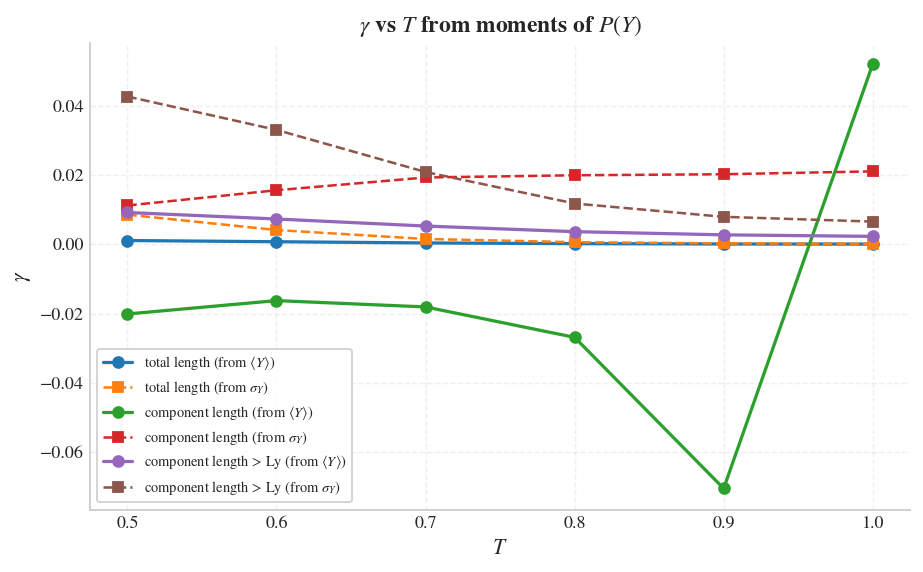

Saved ../results/analysis/summary_plots/combined_y_distributions/mean_over_std_vs_T_from_Y_moments.png


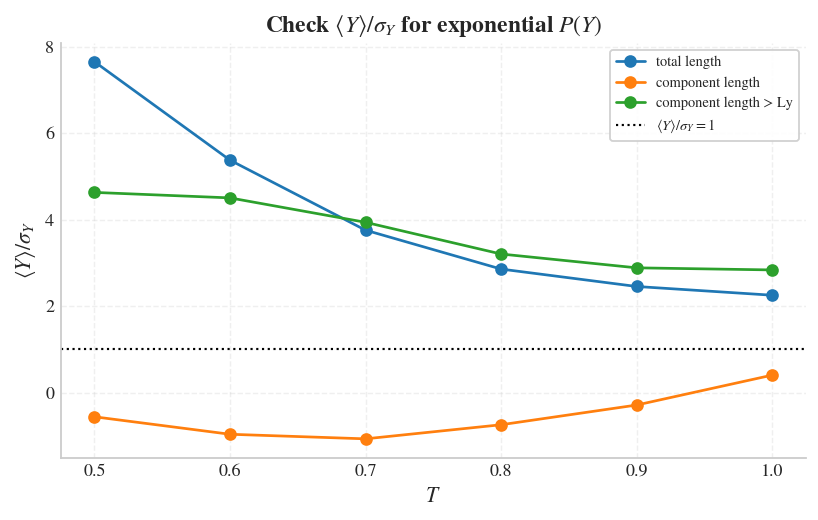

In [5]:
# --- Gamma from moments of P(Y), with Y = Ly*(L^2/Ly^2 - 1) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "apply_plot_style" not in globals():
    def apply_plot_style():
        plt.style.use("seaborn-v0_8-whitegrid")
        plt.rcParams.update({
            "figure.dpi": 130,
            "savefig.dpi": 300,
            "axes.titlesize": 13,
            "axes.titleweight": "semibold",
            "axes.labelsize": 12,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "grid.alpha": 0.28,
            "grid.linestyle": "--",
            "legend.frameon": True,
            "legend.framealpha": 0.9,
            "legend.fancybox": True,
            "legend.edgecolor": "0.8",
            "mathtext.fontset": "stix",
            "font.family": "STIXGeneral",
        })

apply_plot_style()

try:
    from IPython.display import display
except Exception:
    def display(obj):
        print(obj)

if "intervals_y_by_T" not in globals() or "hist_method_specs" not in globals() or "rebin_intervals" not in globals():
    raise RuntimeError("Run the 3rd cell first to build intervals_y_by_T, hist_method_specs, and rebin_intervals.")

if "k_B" not in globals():
    k_B = 1.0

n_bins_mom_y = n_bins_y if "n_bins_y" in globals() else 220
moment_y_min = None  # Use full Y range by default; set 0.0 to restrict to Y >= 0
moment_y_max = None
min_points = 10

# Clear any open figures from earlier cells so inline rendering remains reliable.
plt.close("all")

rows = []
gamma_mean_by_method = {label: [] for label, _ in hist_method_specs}
gamma_std_by_method = {label: [] for label, _ in hist_method_specs}
ratio_by_method = {label: [] for label, _ in hist_method_specs}

for t_val in sorted(intervals_y_by_T.keys()):
    method_map = intervals_y_by_T[t_val]

    spans = []
    for label, _ in hist_method_specs:
        intervals = method_map.get(label, [])
        if intervals:
            spans.append((min(x[0] for x in intervals), max(x[1] for x in intervals)))

    if not spans:
        continue

    y_min = min(s[0] for s in spans)
    y_max = max(s[1] for s in spans)
    if (not np.isfinite(y_min)) or (not np.isfinite(y_max)) or y_max <= y_min:
        continue

    edges = np.linspace(y_min, y_max, n_bins_mom_y + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])

    for label, _ in hist_method_specs:
        intervals = method_map.get(label, [])
        if not intervals:
            continue

        rebinned = rebin_intervals(intervals, edges)
        total = float(rebinned.sum())
        if total <= 0:
            continue

        prob = rebinned / total
        mask = np.isfinite(prob) & (prob > 0)
        if moment_y_min is not None:
            mask &= centers >= moment_y_min
        if moment_y_max is not None:
            mask &= centers <= moment_y_max

        if np.count_nonzero(mask) < min_points:
            print(f"[skip moments] T={t_val:g} | {label}: only {np.count_nonzero(mask)} bins in selected Y range")
            continue

        y = centers[mask]
        p = prob[mask]
        p_mass = float(p.sum())
        if p_mass <= 0:
            continue
        p = p / p_mass

        mean_y = float(np.sum(y * p))
        var_y = float(np.sum((y - mean_y) ** 2 * p))
        std_y = float(np.sqrt(max(var_y, 0.0)))

        if (not np.isfinite(mean_y)) or (not np.isfinite(std_y)) or std_y <= 0:
            print(f"[skip moments] T={t_val:g} | {label}: invalid mean/std ({mean_y}, {std_y})")
            continue

        # P(Y) ~ exp(-gamma*Y/(2*k_B*T))  => mean(Y)=2*k_B*T/gamma, std(Y)=2*k_B*T/gamma
        gamma_from_mean = float(2.0 * k_B * t_val / mean_y)
        gamma_from_std = float(2.0 * k_B * t_val / std_y)
        gamma_avg = 0.5 * (gamma_from_mean + gamma_from_std)
        mean_over_std = float(mean_y / std_y)

        rows.append({
            "T": t_val,
            "method": label,
            "y_min_used": moment_y_min,
            "y_max_used": moment_y_max,
            "selected_probability_mass": p_mass,
            "mean_Y": mean_y,
            "std_Y": std_y,
            "mean_over_std": mean_over_std,
            "gamma_from_mean": gamma_from_mean,
            "gamma_from_std": gamma_from_std,
            "gamma_avg": gamma_avg,
            "n_selected_bins": int(np.count_nonzero(mask)),
            "n_total": int(round(total)),
            "n_lambda": len(lambda_used_y.get(t_val, {}).get(label, set())) if "lambda_used_y" in globals() else np.nan,
        })

        gamma_mean_by_method[label].append((t_val, gamma_from_mean))
        gamma_std_by_method[label].append((t_val, gamma_from_std))
        ratio_by_method[label].append((t_val, mean_over_std))

        print(
            f"T={t_val:g} | {label}: meanY={mean_y:.4g}, stdY={std_y:.4g}, "
            f"gamma(mean)={gamma_from_mean:.4g}, gamma(std)={gamma_from_std:.4g}, "
            f"mean/std={mean_over_std:.4g}, mass={p_mass:.3f}"
        )

if not rows:
    raise RuntimeError("No gamma values were computed from moments. Relax/adjust moment_y_min/moment_y_max.")

df = pd.DataFrame(rows).sort_values(["method", "T"])
out_csv = dist_base_dir / "summary_plots" / "combined_y_distributions" / "gamma_vs_T_from_Y_moments.csv"
df.to_csv(out_csv, index=False)
print(f"Saved {out_csv}")
display_cols = [
    "T",
    "method",
    "mean_Y",
    "std_Y",
    "gamma_from_mean",
    "gamma_from_std",
    "gamma_avg",
    "mean_over_std",
]
print("Moment-based gamma summary:")
display(df[display_cols])

fig, ax = plt.subplots(figsize=(7.2, 4.5))
for label, _ in hist_method_specs:
    pts_mean = sorted(gamma_mean_by_method[label], key=lambda x: x[0])
    pts_std = sorted(gamma_std_by_method[label], key=lambda x: x[0])

    if pts_mean:
        ax.plot(
            [p[0] for p in pts_mean],
            [p[1] for p in pts_mean],
            marker="o",
            linewidth=1.8,
            label=rf'{label} (from $\langle Y \rangle$)',
        )
    if pts_std:
        ax.plot(
            [p[0] for p in pts_std],
            [p[1] for p in pts_std],
            marker="s",
            linestyle="--",
            linewidth=1.4,
            label=rf'{label} (from $\sigma_Y$)',
        )

ax.set_title(r'$\gamma$ vs $T$ from moments of $P(Y)$')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$\gamma$')
ax.grid(True, alpha=0.3)
ax.legend(loc="best", fontsize=8)
fig.tight_layout()

out_plot = dist_base_dir / "summary_plots" / "combined_y_distributions" / "gamma_vs_T_from_Y_moments.png"
fig.savefig(out_plot, dpi=300)
print(f"Saved {out_plot}")
display(fig)
plt.close(fig)

fig, ax = plt.subplots(figsize=(6.4, 4.1))
for label, _ in hist_method_specs:
    pts = sorted(ratio_by_method[label], key=lambda x: x[0])
    if not pts:
        continue
    ax.plot([p[0] for p in pts], [p[1] for p in pts], marker="o", label=label)

ax.axhline(1.0, color="k", linestyle=":", linewidth=1.2, label=r'$\langle Y \rangle/\sigma_Y = 1$')
ax.set_title(r'Check $\langle Y \rangle/\sigma_Y$ for exponential $P(Y)$')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$\langle Y \rangle / \sigma_Y$')
ax.grid(True, alpha=0.3)
ax.legend(loc="best", fontsize=8)
fig.tight_layout()

out_ratio = dist_base_dir / "summary_plots" / "combined_y_distributions" / "mean_over_std_vs_T_from_Y_moments.png"
fig.savefig(out_ratio, dpi=300)
print(f"Saved {out_ratio}")
display(fig)
plt.close(fig)


Saved ../results/analysis/summary_plots/gamma_from_logP_Lmean_slope/logP_vs_L_total_length.png


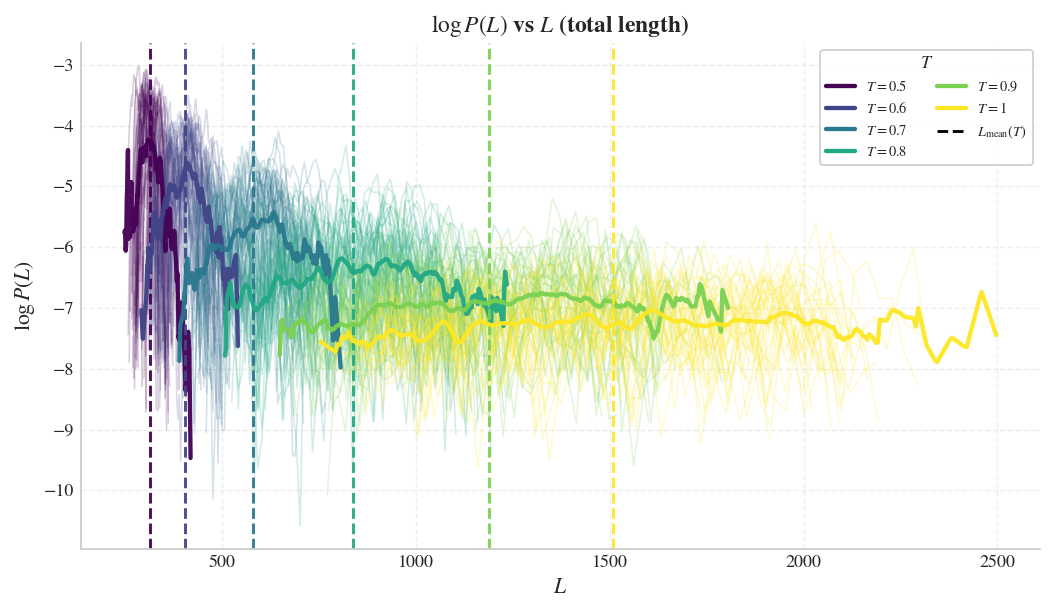

Saved ../results/analysis/summary_plots/gamma_from_logP_Lmean_slope/logP_vs_L_component_length.png


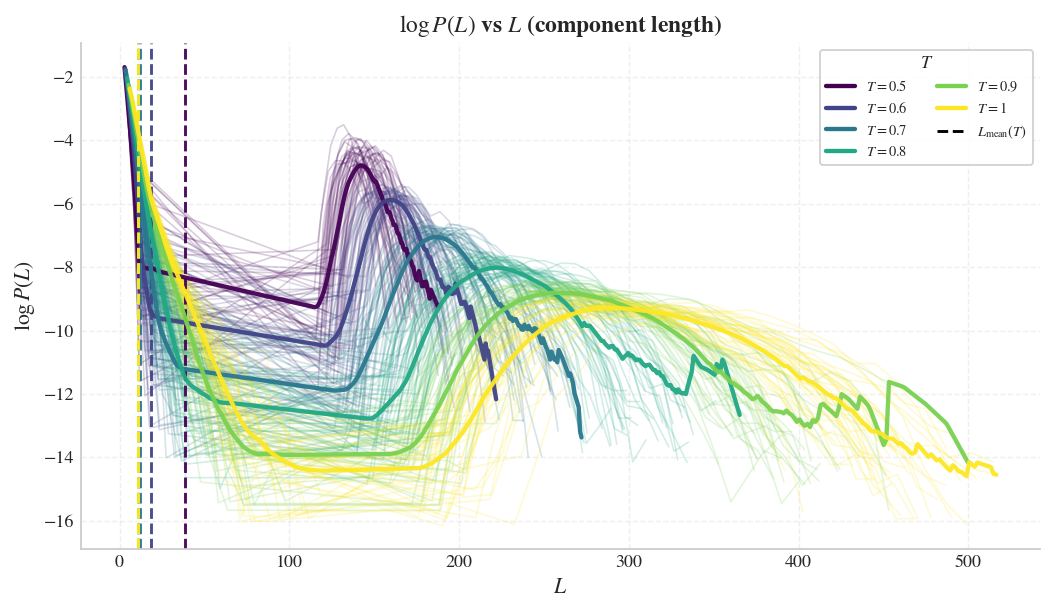

Saved ../results/analysis/summary_plots/gamma_from_logP_Lmean_slope/logP_vs_L_component_length_gt_ly.png


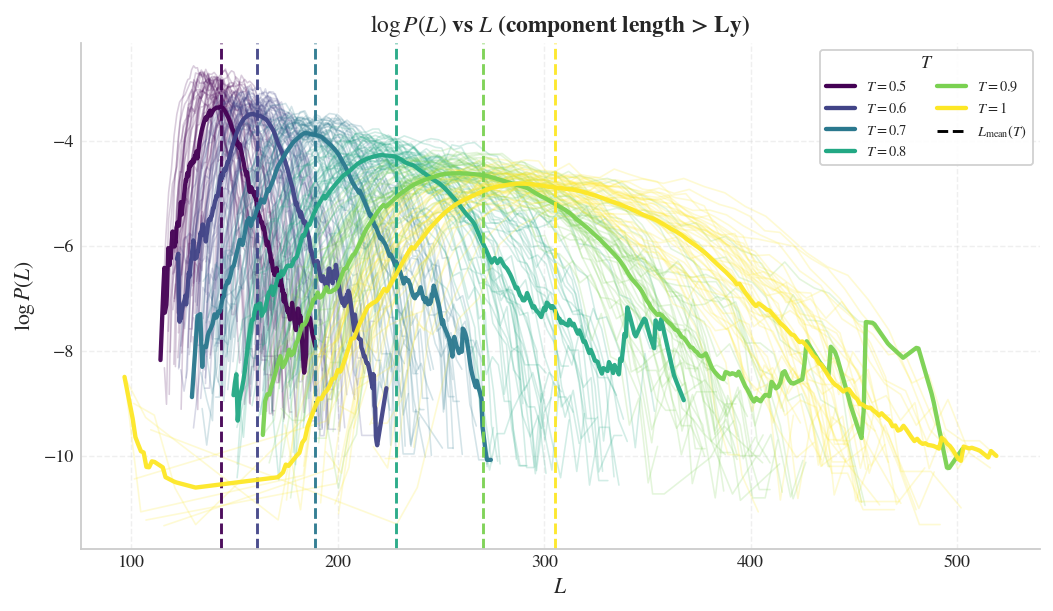

Saved ../results/analysis/summary_plots/gamma_from_logP_Lmean_slope/gamma_by_lambda_from_logP_slope_at_L_mean.csv
Saved ../results/analysis/summary_plots/gamma_from_logP_Lmean_slope/gamma_vs_T_avg_over_lambda_from_logP_slope.csv
                   method    T  gamma_mean  gamma_std  n_lambda
0        component length  0.5    0.007371   0.003958        41
1        component length  0.6    0.014502   0.004643        41
2        component length  0.7    0.029766   0.022444        41
3        component length  0.8    0.053541   0.047164        41
4        component length  0.9    0.111561   0.054489        41
5        component length  1.0    0.133791   0.041532        41
6   component length > Ly  0.5    0.012713   0.013594        41
7   component length > Ly  0.6    0.010296   0.011517        41
8   component length > Ly  0.7    0.008457   0.010654        41
9   component length > Ly  0.8    0.006274   0.011945        41
10  component length > Ly  0.9    0.005196   0.008808        41
11 

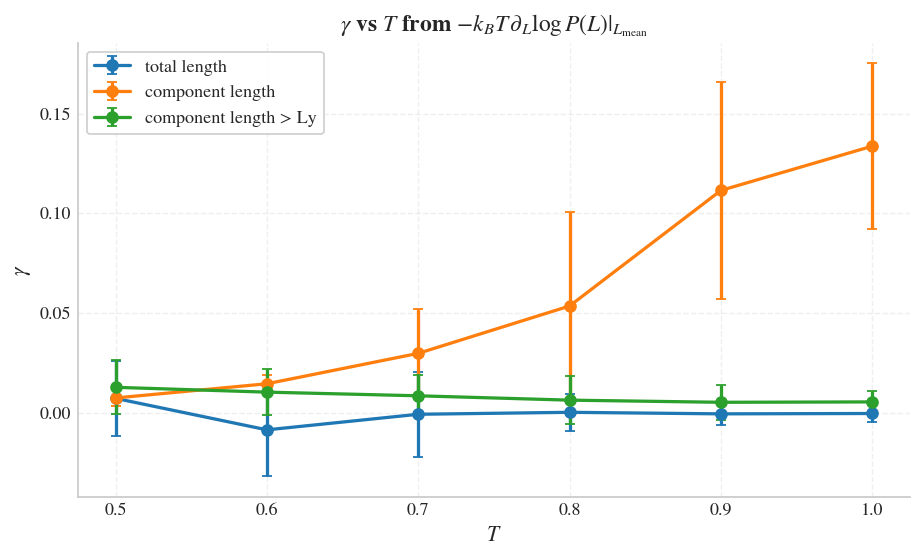

Saved ../results/analysis/summary_plots/gamma_from_logP_Lmean_slope/gamma_by_lambda_from_logP_tail_fit_L_gt_Lpeak.csv
Saved ../results/analysis/summary_plots/gamma_from_logP_Lmean_slope/gamma_vs_T_avg_over_lambda_from_logP_tail_fit_L_gt_Lpeak.csv
                   method    T  gamma_tail_mean  gamma_tail_std  n_lambda  \
0        component length  0.5         0.000665        0.003327        41   
1        component length  0.6         0.002726        0.003960        41   
2        component length  0.7         0.003716        0.002621        41   
3        component length  0.8         0.004292        0.002301        41   
4        component length  0.9         0.004206        0.001884        41   
5        component length  1.0         0.004414        0.001722        41   
6   component length > Ly  0.5         0.101692        0.021358        41   
7   component length > Ly  0.6         0.085658        0.020239        41   
8   component length > Ly  0.7         0.068002        0.015

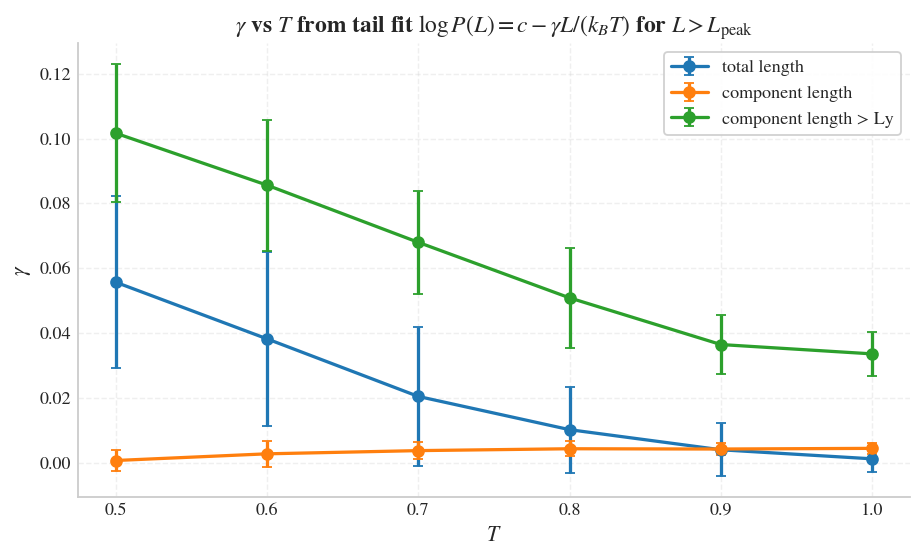

In [6]:
# --- Gamma from d(log P(L))/dL at L_mean for each lambda, then averaged over lambda ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "apply_plot_style" not in globals():
    def apply_plot_style():
        plt.style.use("seaborn-v0_8-whitegrid")
        plt.rcParams.update({
            "figure.dpi": 130,
            "savefig.dpi": 300,
            "axes.titlesize": 13,
            "axes.titleweight": "semibold",
            "axes.labelsize": 12,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "grid.alpha": 0.28,
            "grid.linestyle": "--",
            "legend.frameon": True,
            "legend.framealpha": 0.9,
            "legend.fancybox": True,
            "legend.edgecolor": "0.8",
            "mathtext.fontset": "stix",
            "font.family": "STIXGeneral",
        })

apply_plot_style()

from pathlib import Path

if "k_B" not in globals():
    k_B = 1.0

if "base_dir" in globals():
    slope_base_dir = Path(base_dir)
else:
    slope_candidates = [Path("../results") / "analysis", Path("results") / "analysis"]
    slope_base_dir = next((p for p in slope_candidates if p.exists()), slope_candidates[0])

if not slope_base_dir.exists():
    raise RuntimeError(f"Results directory not found: {slope_base_dir}")

if "hist_method_specs" in globals():
    slope_method_specs = [(item[0], item[1]) for item in hist_method_specs if len(item) >= 2]
else:
    slope_method_specs = [
        ("total length", "ab_network_total_length_hist.csv"),
        ("component length", "ab_network_component_length_hist.csv"),
        ("component length > Ly", "ab_network_component_length_gt_Ly_hist.csv"),
    ]

if not slope_method_specs:
    raise RuntimeError("No histogram methods available for log(P(L)) slope analysis.")


def method_slug(label: str) -> str:
    return (
        label.lower()
        .replace(" ", "_")
        .replace(">", "gt")
        .replace("<", "lt")
        .replace("/", "_")
    )


def local_linear_slope(x: np.ndarray, y: np.ndarray, x0: float, target_points: int = 7, min_points: int = 4) -> float:
    if x.size < min_points:
        return np.nan

    order = np.argsort(np.abs(x - x0))
    chosen = np.sort(order[: min(target_points, x.size)])
    xw = x[chosen]
    yw = y[chosen]

    if xw.size < min_points:
        return np.nan
    if np.ptp(xw) <= 0:
        return np.nan

    slope, _ = np.polyfit(xw, yw, 1)
    return float(slope)


rows = []
rows_tail = []
logp_curves_by_method = {label: [] for label, _ in slope_method_specs}

for t_dir in sorted(slope_base_dir.glob("T_*")):
    if not t_dir.is_dir():
        continue

    try:
        t_val = float(t_dir.name.split("T_")[1])
    except Exception:
        continue

    for lambda_dir in sorted(t_dir.glob("lambda_*")):
        if not lambda_dir.is_dir():
            continue

        try:
            lam_val = float(lambda_dir.name.split("lambda_")[1])
        except Exception:
            continue

        for label, hist_name in slope_method_specs:
            hist_path = lambda_dir / hist_name
            if not hist_path.exists():
                continue

            df = pd.read_csv(hist_path)
            required = {"bin_left", "bin_right", "count"}
            if not required.issubset(df.columns):
                print(f"[skip] {hist_path} missing required columns {required}")
                continue

            left = df["bin_left"].to_numpy(dtype=float)
            right = df["bin_right"].to_numpy(dtype=float)
            count = df["count"].to_numpy(dtype=float)

            valid = np.isfinite(left) & np.isfinite(right) & np.isfinite(count) & (count > 0) & (right > left)
            if np.count_nonzero(valid) < 4:
                continue

            left = left[valid]
            right = right[valid]
            count = count[valid]
            width = right - left
            center = 0.5 * (left + right)

            total_count = float(np.sum(count))
            if total_count <= 0:
                continue

            prob_density = count / (total_count * width)

            mask = np.isfinite(center) & np.isfinite(prob_density) & (prob_density > 0)
            if np.count_nonzero(mask) < 4:
                continue

            center = center[mask]
            prob_density = prob_density[mask]

            order = np.argsort(center)
            center = center[order]
            prob_density = prob_density[order]

            unique_center, unique_idx = np.unique(center, return_index=True)
            center = unique_center
            prob_density = prob_density[unique_idx]

            if center.size < 4:
                continue

            logp = np.log(prob_density)
            l_mean = float(np.sum(count * 0.5 * (left + right)) / total_count)
            peak_idx = int(np.argmax(logp))
            l_peak = float(center[peak_idx])

            # Tail fit: log P(L) = c - gamma/(k_B T) * L for L > L_peak.
            tail_mask = center > l_peak
            if np.count_nonzero(tail_mask) >= 4 and np.ptp(center[tail_mask]) > 0:
                x_tail = center[tail_mask]
                y_tail = logp[tail_mask]
                slope_tail, intercept_tail = np.polyfit(x_tail, y_tail, 1)
                slope_tail = float(slope_tail)
                intercept_tail = float(intercept_tail)

                y_tail_hat = slope_tail * x_tail + intercept_tail
                ss_res_tail = float(np.sum((y_tail - y_tail_hat) ** 2))
                ss_tot_tail = float(np.sum((y_tail - y_tail.mean()) ** 2))
                r2_tail = float(1.0 - ss_res_tail / ss_tot_tail) if ss_tot_tail > 0 else np.nan

                gamma_tail = float(-k_B * t_val * slope_tail)
                rows_tail.append(
                    {
                        "T": t_val,
                        "lambda": lam_val,
                        "method": label,
                        "L_peak": l_peak,
                        "slope_logP_vs_L_tail": slope_tail,
                        "intercept_tail": intercept_tail,
                        "r2_tail": r2_tail,
                        "n_tail_points": int(np.count_nonzero(tail_mask)),
                        "gamma_tail": gamma_tail,
                    }
                )

            dlogp_dL = local_linear_slope(center, logp, l_mean)
            if not np.isfinite(dlogp_dL):
                continue

            gamma_val = float(-k_B * t_val * dlogp_dL)

            rows.append(
                {
                    "T": t_val,
                    "lambda": lam_val,
                    "method": label,
                    "L_mean": l_mean,
                    "dlogP_dL_at_L_mean": dlogp_dL,
                    "gamma": gamma_val,
                    "n_bins_used": int(center.size),
                    "total_count": int(round(total_count)),
                }
            )

            logp_curves_by_method[label].append(
                {
                    "T": t_val,
                    "lambda": lam_val,
                    "L": center,
                    "logP": logp,
                    "L_mean": l_mean,
                }
            )

if not rows:
    raise RuntimeError("No gamma values computed from d(log P(L))/dL. Check histogram files and bin counts.")

out_dir = slope_base_dir / "summary_plots" / "gamma_from_logP_Lmean_slope"
out_dir.mkdir(parents=True, exist_ok=True)

# 1) log(P(L)) vs L for each method
from matplotlib.lines import Line2D

for label, _ in slope_method_specs:
    curves = sorted(logp_curves_by_method.get(label, []), key=lambda r: (r["T"], r["lambda"]))
    if not curves:
        continue

    t_values = sorted({float(rec["T"]) for rec in curves})
    cmap = plt.get_cmap("viridis", max(len(t_values), 2))
    t_to_color = {t_val: cmap(i) for i, t_val in enumerate(t_values)}

    fig, ax = plt.subplots(figsize=(8.2, 4.8))

    # Plot each lambda curve with low opacity; temperature is encoded by color.
    for rec in curves:
        t_val = float(rec["T"])
        color = t_to_color[t_val]
        ax.plot(rec["L"], rec["logP"], linewidth=0.9, alpha=0.20, color=color)

    # Overlay a bold average curve for each temperature for clear visual separation.
    for t_val in t_values:
        t_curves = [rec for rec in curves if abs(float(rec["T"]) - t_val) < 1e-12]
        if not t_curves:
            continue

        x_min = min(float(np.min(rec["L"])) for rec in t_curves)
        x_max = max(float(np.max(rec["L"])) for rec in t_curves)
        if not np.isfinite(x_min) or not np.isfinite(x_max) or x_max <= x_min:
            continue

        x_grid = np.linspace(x_min, x_max, 320)
        y_stack = np.full((len(t_curves), x_grid.size), np.nan, dtype=float)

        for i, rec in enumerate(t_curves):
            x = np.asarray(rec["L"], dtype=float)
            y = np.asarray(rec["logP"], dtype=float)
            mask = np.isfinite(x) & np.isfinite(y)
            x = x[mask]
            y = y[mask]
            if x.size < 2:
                continue

            order = np.argsort(x)
            x = x[order]
            y = y[order]
            x_unique, idx_unique = np.unique(x, return_index=True)
            x = x_unique
            y = y[idx_unique]
            if x.size < 2:
                continue

            in_range = (x_grid >= x[0]) & (x_grid <= x[-1])
            if np.any(in_range):
                y_stack[i, in_range] = np.interp(x_grid[in_range], x, y)

        y_mean = np.nanmean(y_stack, axis=0)
        valid = np.isfinite(y_mean)
        if np.any(valid):
            ax.plot(
                x_grid[valid],
                y_mean[valid],
                linewidth=2.4,
                alpha=0.95,
                color=t_to_color[t_val],
            )

        l_means = np.asarray([rec["L_mean"] for rec in t_curves], dtype=float)
        l_means = l_means[np.isfinite(l_means)]
        if l_means.size > 0:
            l_mean_t = float(np.mean(l_means))
            ax.axvline(
                l_mean_t,
                color=t_to_color[t_val],
                linestyle="--",
                linewidth=1.6,
                alpha=0.95,
            )

    temp_handles = [
        Line2D([0], [0], color=t_to_color[t_val], lw=2.4, label=rf'$T={t_val:g}$')
        for t_val in t_values
    ]
    temp_handles.append(Line2D([0], [0], color="black", lw=1.6, ls="--", label=r'$L_{\mathrm{mean}}(T)$'))

    ax.set_title(rf'$\log P(L)$ vs $L$ ({label})')
    ax.set_xlabel(r'$L$')
    ax.set_ylabel(r'$\log P(L)$')
    ax.grid(True, alpha=0.3)
    ax.legend(handles=temp_handles, title=r'$T$', loc="best", fontsize=8, ncol=2)
    fig.tight_layout()

    out_plot = out_dir / f"logP_vs_L_{method_slug(label)}.png"
    fig.savefig(out_plot, dpi=300)
    print(f"Saved {out_plot}")
    plt.show()

# 2) Gamma at L_mean for each (T, lambda, method)
df_lambda = pd.DataFrame(rows).sort_values(["method", "T", "lambda"])
out_csv_lambda = out_dir / "gamma_by_lambda_from_logP_slope_at_L_mean.csv"
df_lambda.to_csv(out_csv_lambda, index=False)
print(f"Saved {out_csv_lambda}")

# 3) Average gamma over lambda for each T (separately by method)
df_avg = (
    df_lambda.groupby(["method", "T"], as_index=False)
    .agg(
        gamma_mean=("gamma", "mean"),
        gamma_std=("gamma", "std"),
        n_lambda=("lambda", "nunique"),
    )
    .sort_values(["method", "T"])
)
df_avg["gamma_std"] = df_avg["gamma_std"].fillna(0.0)
out_csv_avg = out_dir / "gamma_vs_T_avg_over_lambda_from_logP_slope.csv"
df_avg.to_csv(out_csv_avg, index=False)
print(f"Saved {out_csv_avg}")
print(df_avg)

# 4) Plot gamma vs T (lambda-averaged)
fig, ax = plt.subplots(figsize=(7.2, 4.4))
for label, _ in slope_method_specs:
    sub = df_avg[df_avg["method"] == label].sort_values("T")
    if sub.empty:
        continue
    ax.errorbar(
        sub["T"],
        sub["gamma_mean"],
        yerr=sub["gamma_std"],
        marker="o",
        linewidth=1.8,
        capsize=3,
        label=label,
    )

ax.set_title(r'$\gamma$ vs $T$ from $-k_B T\,\partial_L \log P(L)\vert_{L_{\mathrm{mean}}}$')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$\gamma$')
ax.grid(True, alpha=0.3)
ax.legend(loc="best")
fig.tight_layout()

out_plot_gamma = out_dir / "gamma_vs_T_avg_over_lambda_from_logP_slope.png"
fig.savefig(out_plot_gamma, dpi=300)
print(f"Saved {out_plot_gamma}")
plt.show()

# 5) Tail-fit gamma from log P(L) = c - gamma/(k_B T) * L for L > L_peak
if not rows_tail:
    print('[warn] No tail-fit gamma values computed for L > L_peak.')
else:
    df_tail_lambda = pd.DataFrame(rows_tail).sort_values(["method", "T", "lambda"])
    out_csv_tail_lambda = out_dir / "gamma_by_lambda_from_logP_tail_fit_L_gt_Lpeak.csv"
    df_tail_lambda.to_csv(out_csv_tail_lambda, index=False)
    print(f"Saved {out_csv_tail_lambda}")

    df_tail_avg = (
        df_tail_lambda.groupby(["method", "T"], as_index=False)
        .agg(
            gamma_tail_mean=("gamma_tail", "mean"),
            gamma_tail_std=("gamma_tail", "std"),
            n_lambda=("lambda", "nunique"),
            mean_r2_tail=("r2_tail", "mean"),
            mean_L_peak=("L_peak", "mean"),
        )
        .sort_values(["method", "T"])
    )
    df_tail_avg["gamma_tail_std"] = df_tail_avg["gamma_tail_std"].fillna(0.0)

    out_csv_tail_avg = out_dir / "gamma_vs_T_avg_over_lambda_from_logP_tail_fit_L_gt_Lpeak.csv"
    df_tail_avg.to_csv(out_csv_tail_avg, index=False)
    print(f"Saved {out_csv_tail_avg}")
    print(df_tail_avg)

    fig, ax = plt.subplots(figsize=(7.2, 4.4))
    for label, _ in slope_method_specs:
        sub = df_tail_avg[df_tail_avg["method"] == label].sort_values("T")
        if sub.empty:
            continue
        ax.errorbar(
            sub["T"],
            sub["gamma_tail_mean"],
            yerr=sub["gamma_tail_std"],
            marker="o",
            linewidth=1.8,
            capsize=3,
            label=label,
        )

    ax.set_title(r'$\gamma$ vs $T$ from tail fit $\log P(L)=c-\gamma L/(k_B T)$ for $L>L_{\mathrm{peak}}$')
    ax.set_xlabel(r'$T$')
    ax.set_ylabel(r'$\gamma$')
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
    fig.tight_layout()

    out_plot_tail = out_dir / "gamma_vs_T_avg_over_lambda_from_logP_tail_fit_L_gt_Lpeak.png"
    fig.savefig(out_plot_tail, dpi=300)
    print(f"Saved {out_plot_tail}")
    plt.show()


Saved ../results/analysis/summary_plots/k_eff_from_logP_peak_quadratic_fit/k_eff_by_lambda_from_logP_peak_quadratic_fit.csv
Saved ../results/analysis/summary_plots/k_eff_from_logP_peak_quadratic_fit/k_eff_vs_T_avg_over_lambda_from_logP_peak_quadratic_fit.csv
Saved ../results/analysis/summary_plots/k_eff_from_logP_peak_quadratic_fit/gamma_vs_T_avg_over_lambda_from_keff_times_stdL.csv
Saved ../results/analysis/summary_plots/k_eff_from_logP_peak_quadratic_fit/gamma_vs_T_avg_over_lambda_from_keff_intPL.csv
Saved ../results/analysis/summary_plots/k_eff_from_logP_peak_quadratic_fit/gamma_vs_T_avg_over_lambda_from_keff_Ldev.csv
Saved ../results/analysis/summary_plots/k_eff_from_logP_peak_quadratic_fit/gamma_vs_T_avg_over_lambda_from_keff_peak_quad.csv
                   method    T  k_eff_mean  k_eff_std  gamma_mean  gamma_std  \
0        component length  0.5   -0.007036   0.007367   -0.410342   0.372986   
1        component length  0.6   -0.005412   0.001467   -0.248924   0.069158   
2    

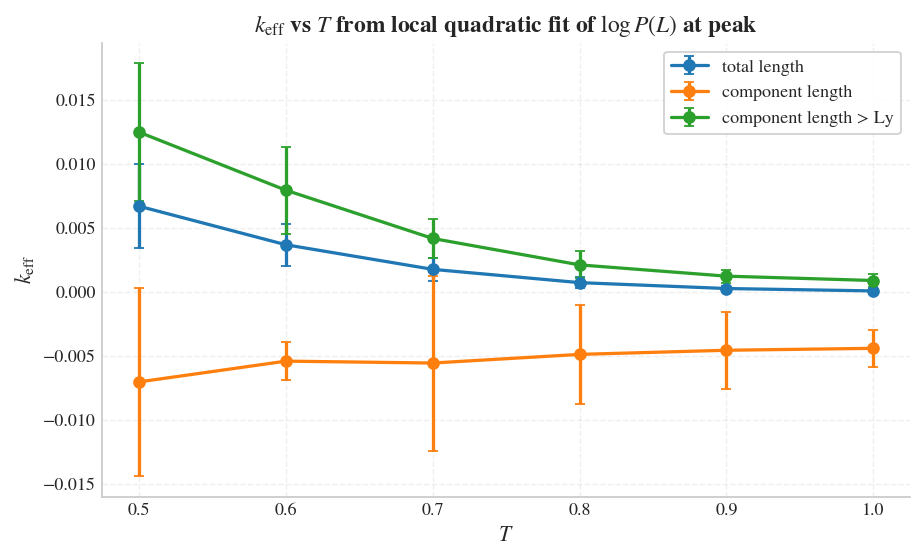

Saved ../results/analysis/summary_plots/k_eff_from_logP_peak_quadratic_fit/gamma_vs_T_avg_over_lambda_from_keff_times_stdL.png


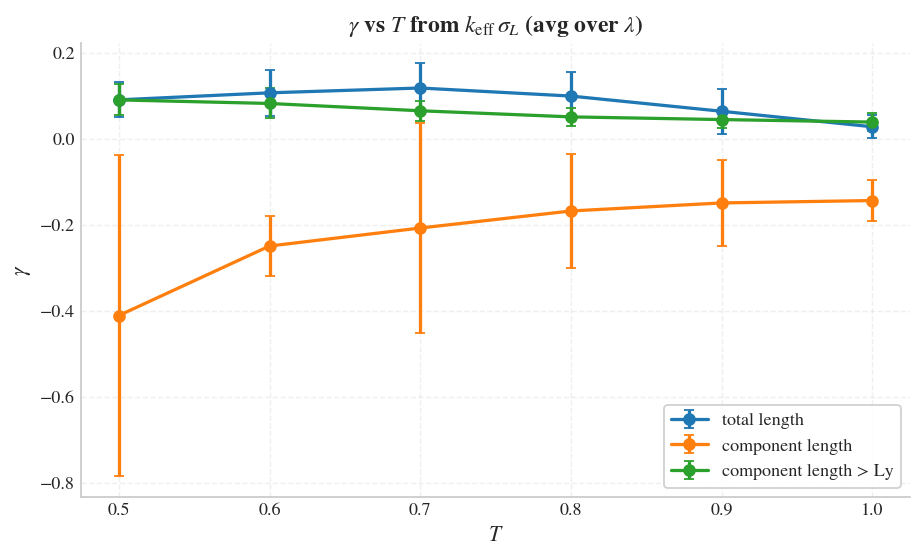

Saved ../results/analysis/summary_plots/k_eff_from_logP_peak_quadratic_fit/gamma_vs_T_avg_over_lambda_from_keff_intPL.png


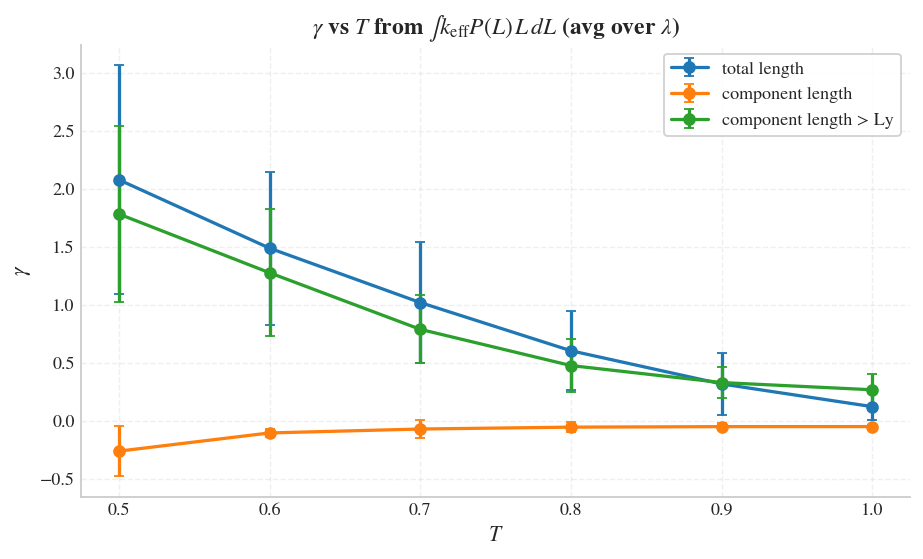

Saved ../results/analysis/summary_plots/k_eff_from_logP_peak_quadratic_fit/gamma_vs_T_avg_over_lambda_from_keff_Ldev.png


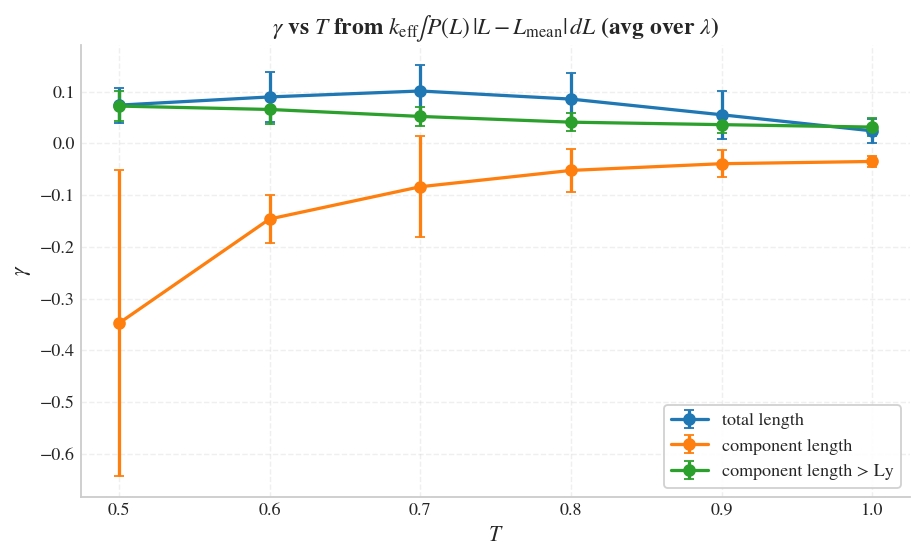

Saved ../results/analysis/summary_plots/k_eff_from_logP_peak_quadratic_fit/gamma_vs_T_avg_over_lambda_from_keff_peak_quad.png


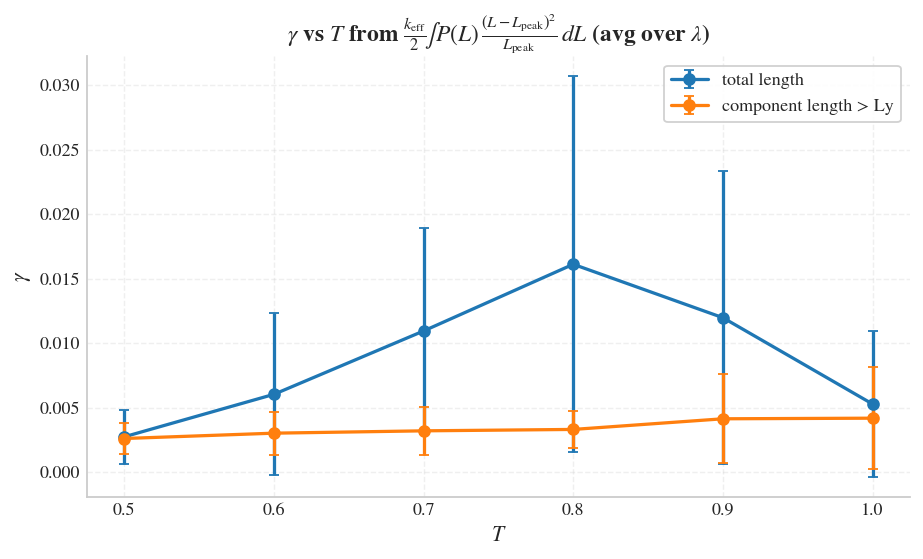

In [7]:
# --- k_eff from local quadratic fit of log(P(L)) around peak L0, averaged over lambda ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "apply_plot_style" not in globals():
    def apply_plot_style():
        plt.style.use("seaborn-v0_8-whitegrid")
        plt.rcParams.update({
            "figure.dpi": 130,
            "savefig.dpi": 300,
            "axes.titlesize": 13,
            "axes.titleweight": "semibold",
            "axes.labelsize": 12,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "grid.alpha": 0.28,
            "grid.linestyle": "--",
            "legend.frameon": True,
            "legend.framealpha": 0.9,
            "legend.fancybox": True,
            "legend.edgecolor": "0.8",
            "mathtext.fontset": "stix",
            "font.family": "STIXGeneral",
        })

apply_plot_style()

from pathlib import Path

if "k_B" not in globals():
    k_B = 1.0

if "base_dir" in globals():
    keff_base_dir = Path(base_dir)
else:
    keff_candidates = [Path("../results") / "analysis", Path("results") / "analysis"]
    keff_base_dir = next((p for p in keff_candidates if p.exists()), keff_candidates[0])

if not keff_base_dir.exists():
    raise RuntimeError(f"Results directory not found: {keff_base_dir}")

if "hist_method_specs" in globals():
    keff_method_specs = [(item[0], item[1]) for item in hist_method_specs if len(item) >= 2]
else:
    keff_method_specs = [
        ("total length", "ab_network_total_length_hist.csv"),
        ("component length", "ab_network_component_length_hist.csv"),
        ("component length > Ly", "ab_network_component_length_gt_Ly_hist.csv"),
    ]

if not keff_method_specs:
    raise RuntimeError("No histogram methods available for k_eff fit.")

fit_half_window_bins = 4  # local fit uses 2*half_window+1 bins around peak
min_fit_points = 5


def fit_quadratic_near_peak(x_full: np.ndarray, y_full: np.ndarray, peak_idx: int):
    lo = max(0, peak_idx - fit_half_window_bins)
    hi = min(x_full.size, peak_idx + fit_half_window_bins + 1)

    x = x_full[lo:hi]
    y = y_full[lo:hi]
    valid = np.isfinite(x) & np.isfinite(y)
    x = x[valid]
    y = y[valid]

    if x.size < min_fit_points:
        return np.nan, np.nan, np.nan, np.nan, np.nan, 0
    if np.ptp(x) <= 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan, int(x.size)

    x0 = float(x_full[peak_idx])
    z = x - x0

    a_stderr = np.nan
    try:
        coeffs, cov = np.polyfit(z, y, 2, cov=True)
        a2, a1, a0 = [float(v) for v in coeffs]
        if np.isfinite(cov[0, 0]) and cov[0, 0] >= 0:
            a_stderr = float(np.sqrt(cov[0, 0]))
    except Exception:
        a2, a1, a0 = np.polyfit(z, y, 2)
        a2, a1, a0 = float(a2), float(a1), float(a0)

    y_hat = a2 * z * z + a1 * z + a0
    ss_res = float(np.sum((y - y_hat) ** 2))
    ss_tot = float(np.sum((y - y.mean()) ** 2))
    r2 = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else np.nan

    return a2, a1, a0, a_stderr, r2, int(x.size)


rows = []
for t_dir in sorted(keff_base_dir.glob("T_*")):
    if not t_dir.is_dir():
        continue

    try:
        t_val = float(t_dir.name.split("T_")[1])
    except Exception:
        continue

    for lambda_dir in sorted(t_dir.glob("lambda_*")):
        if not lambda_dir.is_dir():
            continue

        try:
            lam_val = float(lambda_dir.name.split("lambda_")[1])
        except Exception:
            continue

        for label, hist_name in keff_method_specs:
            hist_path = lambda_dir / hist_name
            if not hist_path.exists():
                continue

            df = pd.read_csv(hist_path)
            required = {"bin_left", "bin_right", "count"}
            if not required.issubset(df.columns):
                print(f"[skip] {hist_path} missing required columns {required}")
                continue

            left = df["bin_left"].to_numpy(dtype=float)
            right = df["bin_right"].to_numpy(dtype=float)
            count = df["count"].to_numpy(dtype=float)

            valid = np.isfinite(left) & np.isfinite(right) & np.isfinite(count) & (count > 0) & (right > left)
            if np.count_nonzero(valid) < min_fit_points:
                continue

            left = left[valid]
            right = right[valid]
            count = count[valid]

            width = right - left
            center = 0.5 * (left + right)
            total_count = float(np.sum(count))
            if total_count <= 0:
                continue

            # Moments from piecewise-uniform bins for std(L).
            mean_l = float(np.sum(count * 0.5 * (left + right)) / total_count)
            mean_l2 = float(np.sum(count * (left * left + left * right + right * right) / 3.0) / total_count)
            var_l = max(mean_l2 - mean_l * mean_l, 0.0)
            std_l = float(np.sqrt(var_l))

            # integral P(L)*L dL using piecewise-uniform bins.
            prob_density_all = count / (total_count * width)
            integral_p_l = float(np.sum(prob_density_all * 0.5 * (right * right - left * left)))

            # L_dev = integral P(L) * |L - L_mean| dL.
            abs_dev_bin = np.where(
                right <= mean_l,
                mean_l * (right - left) - 0.5 * (right * right - left * left),
                np.where(
                    left >= mean_l,
                    0.5 * (right * right - left * left) - mean_l * (right - left),
                    0.5 * (mean_l - left) ** 2 + 0.5 * (right - mean_l) ** 2,
                ),
            )
            integral_p_l_dev = float(np.sum(prob_density_all * abs_dev_bin))

            prob_density = prob_density_all
            mask = np.isfinite(center) & np.isfinite(prob_density) & (prob_density > 0)
            if np.count_nonzero(mask) < min_fit_points:
                continue

            center = center[mask]
            prob_density = prob_density[mask]

            order = np.argsort(center)
            center = center[order]
            prob_density = prob_density[order]

            center_unique, unique_idx = np.unique(center, return_index=True)
            center = center_unique
            prob_density = prob_density[unique_idx]
            if center.size < min_fit_points:
                continue

            logp = np.log(prob_density)
            peak_idx = int(np.argmax(logp))
            l0_peak = float(center[peak_idx])

            if np.isfinite(l0_peak) and l0_peak > 0:
                integral_p_peak_quad = float(
                    np.sum(
                        prob_density_all
                        * (((right - l0_peak) ** 3 - (left - l0_peak) ** 3) / (3.0 * l0_peak))
                    )
                )
            else:
                integral_p_peak_quad = np.nan

            a2, a1, a0, a2_stderr, r2, n_fit_points = fit_quadratic_near_peak(center, logp, peak_idx)
            if not np.isfinite(a2):
                continue

            is_concave = bool(a2 < 0)
            k_eff = float(-2.0 * k_B * t_val * a2)
            k_eff_stderr = float(2.0 * k_B * t_val * a2_stderr) if np.isfinite(a2_stderr) else np.nan
            gamma_from_keff_stdL = float(k_eff * std_l)
            gamma_from_keff_intPL = float(k_eff * integral_p_l)
            gamma_from_keff_Ldev = float(k_eff * integral_p_l_dev)
            gamma_from_keff_peak_quad = (
                float(0.5 * k_eff * integral_p_peak_quad)
                if np.isfinite(integral_p_peak_quad)
                else np.nan
            )

            rows.append(
                {
                    "T": t_val,
                    "lambda": lam_val,
                    "method": label,
                    "L0_from_logP_peak": l0_peak,
                    "mean_L": mean_l,
                    "std_L": std_l,
                    "integral_P_times_L": integral_p_l,
                    "integral_P_times_L_dev": integral_p_l_dev,
                    "integral_P_times_dL2_over_Lpeak": integral_p_peak_quad,
                    "a2_quadratic": a2,
                    "a2_stderr": a2_stderr,
                    "a1_linear": a1,
                    "a0_const": a0,
                    "r2_local_fit": r2,
                    "is_concave": is_concave,
                    "n_fit_points": n_fit_points,
                    "n_bins_used": int(center.size),
                    "total_count": int(round(total_count)),
                    "k_eff": k_eff,
                    "k_eff_stderr": k_eff_stderr,
                    "gamma_from_keff_stdL": gamma_from_keff_stdL,
                    "gamma_from_keff_intPL": gamma_from_keff_intPL,
                    "gamma_from_keff_Ldev": gamma_from_keff_Ldev,
                    "gamma_from_keff_peak_quad": gamma_from_keff_peak_quad,
                }
            )

if not rows:
    raise RuntimeError("No valid k_eff values from local quadratic peak fit.")

out_dir = keff_base_dir / "summary_plots" / "k_eff_from_logP_peak_quadratic_fit"
out_dir.mkdir(parents=True, exist_ok=True)

# Per-(T,lambda) results
df_lambda = pd.DataFrame(rows).sort_values(["method", "T", "lambda"])
out_csv_lambda = out_dir / "k_eff_by_lambda_from_logP_peak_quadratic_fit.csv"
df_lambda.to_csv(out_csv_lambda, index=False)
print(f"Saved {out_csv_lambda}")

# Average over lambda at fixed (method, T)
df_avg = (
    df_lambda.groupby(["method", "T"], as_index=False)
    .agg(
        k_eff_mean=("k_eff", "mean"),
        k_eff_std=("k_eff", "std"),
        gamma_mean=("gamma_from_keff_stdL", "mean"),
        gamma_std=("gamma_from_keff_stdL", "std"),
        gamma_int_mean=("gamma_from_keff_intPL", "mean"),
        gamma_int_std=("gamma_from_keff_intPL", "std"),
        gamma_Ldev_mean=("gamma_from_keff_Ldev", "mean"),
        gamma_Ldev_std=("gamma_from_keff_Ldev", "std"),
        gamma_peak_quad_mean=("gamma_from_keff_peak_quad", "mean"),
        gamma_peak_quad_std=("gamma_from_keff_peak_quad", "std"),
        mean_std_L=("std_L", "mean"),
        mean_integral_P_times_L=("integral_P_times_L", "mean"),
        mean_integral_P_times_L_dev=("integral_P_times_L_dev", "mean"),
        mean_integral_P_times_dL2_over_Lpeak=("integral_P_times_dL2_over_Lpeak", "mean"),
        n_lambda=("lambda", "nunique"),
        mean_r2_local=("r2_local_fit", "mean"),
        mean_L0_peak=("L0_from_logP_peak", "mean"),
        concave_fraction=("is_concave", "mean"),
    )
    .sort_values(["method", "T"])
)
df_avg["k_eff_std"] = df_avg["k_eff_std"].fillna(0.0)
df_avg["gamma_std"] = df_avg["gamma_std"].fillna(0.0)
df_avg["gamma_int_std"] = df_avg["gamma_int_std"].fillna(0.0)
df_avg["gamma_Ldev_std"] = df_avg["gamma_Ldev_std"].fillna(0.0)
df_avg["gamma_peak_quad_std"] = df_avg["gamma_peak_quad_std"].fillna(0.0)

out_csv_avg = out_dir / "k_eff_vs_T_avg_over_lambda_from_logP_peak_quadratic_fit.csv"
df_avg.to_csv(out_csv_avg, index=False)
print(f"Saved {out_csv_avg}")

out_csv_gamma = out_dir / "gamma_vs_T_avg_over_lambda_from_keff_times_stdL.csv"
df_avg[["method", "T", "gamma_mean", "gamma_std", "mean_std_L", "n_lambda"]].to_csv(out_csv_gamma, index=False)
print(f"Saved {out_csv_gamma}")

out_csv_gamma_int = out_dir / "gamma_vs_T_avg_over_lambda_from_keff_intPL.csv"
df_avg[["method", "T", "gamma_int_mean", "gamma_int_std", "mean_integral_P_times_L", "n_lambda"]].to_csv(out_csv_gamma_int, index=False)
print(f"Saved {out_csv_gamma_int}")

out_csv_gamma_ldev = out_dir / "gamma_vs_T_avg_over_lambda_from_keff_Ldev.csv"
df_avg[["method", "T", "gamma_Ldev_mean", "gamma_Ldev_std", "mean_integral_P_times_L_dev", "n_lambda"]].to_csv(out_csv_gamma_ldev, index=False)
print(f"Saved {out_csv_gamma_ldev}")

out_csv_gamma_peak_quad = out_dir / "gamma_vs_T_avg_over_lambda_from_keff_peak_quad.csv"
df_avg[["method", "T", "gamma_peak_quad_mean", "gamma_peak_quad_std", "mean_integral_P_times_dL2_over_Lpeak", "n_lambda"]].to_csv(out_csv_gamma_peak_quad, index=False)
print(f"Saved {out_csv_gamma_peak_quad}")
print(df_avg)

# Plot k_eff vs T
fig, ax = plt.subplots(figsize=(7.2, 4.4))
for label, _ in keff_method_specs:
    sub = df_avg[df_avg["method"] == label].sort_values("T")
    if sub.empty:
        continue
    ax.errorbar(
        sub["T"],
        sub["k_eff_mean"],
        yerr=sub["k_eff_std"],
        marker="o",
        linewidth=1.8,
        capsize=3,
        label=label,
    )

ax.set_title(r'$k_{\mathrm{eff}}$ vs $T$ from local quadratic fit of $\log P(L)$ at peak')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$k_{\mathrm{eff}}$')
ax.grid(True, alpha=0.3)
ax.legend(loc="best")
fig.tight_layout()

out_plot = out_dir / "k_eff_vs_T_avg_over_lambda_from_logP_peak_quadratic_fit.png"
fig.savefig(out_plot, dpi=300)
print(f"Saved {out_plot}")
plt.show()

# Plot gamma vs T where gamma = k_eff * std(L)
fig, ax = plt.subplots(figsize=(7.2, 4.4))
for label, _ in keff_method_specs:
    sub = df_avg[df_avg["method"] == label].sort_values("T")
    if sub.empty:
        continue
    ax.errorbar(
        sub["T"],
        sub["gamma_mean"],
        yerr=sub["gamma_std"],
        marker="o",
        linewidth=1.8,
        capsize=3,
        label=label,
    )

ax.set_title(r'$\gamma$ vs $T$ from $k_{\mathrm{eff}}\,\sigma_L$ (avg over $\lambda$)')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$\gamma$')
ax.grid(True, alpha=0.3)
ax.legend(loc="best")
fig.tight_layout()

out_plot_gamma = out_dir / "gamma_vs_T_avg_over_lambda_from_keff_times_stdL.png"
fig.savefig(out_plot_gamma, dpi=300)
print(f"Saved {out_plot_gamma}")
plt.show()

# Plot gamma vs T where gamma = integral k_eff*P(L)*L dL
fig, ax = plt.subplots(figsize=(7.2, 4.4))
for label, _ in keff_method_specs:
    sub = df_avg[df_avg["method"] == label].sort_values("T")
    if sub.empty:
        continue
    ax.errorbar(
        sub["T"],
        sub["gamma_int_mean"],
        yerr=sub["gamma_int_std"],
        marker="o",
        linewidth=1.8,
        capsize=3,
        label=label,
    )

ax.set_title(r'$\gamma$ vs $T$ from $\int k_{\mathrm{eff}} P(L)\,L\,dL$ (avg over $\lambda$)')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$\gamma$')
ax.grid(True, alpha=0.3)
ax.legend(loc="best")
fig.tight_layout()

out_plot_gamma_int = out_dir / "gamma_vs_T_avg_over_lambda_from_keff_intPL.png"
fig.savefig(out_plot_gamma_int, dpi=300)
print(f"Saved {out_plot_gamma_int}")
plt.show()


# Plot gamma vs T where gamma = k_eff * integral P(L)*(L - L_mean) dL
fig, ax = plt.subplots(figsize=(7.2, 4.4))
for label, _ in keff_method_specs:
    sub = df_avg[df_avg["method"] == label].sort_values("T")
    if sub.empty:
        continue
    ax.errorbar(
        sub["T"],
        sub["gamma_Ldev_mean"],
        yerr=sub["gamma_Ldev_std"],
        marker="o",
        linewidth=1.8,
        capsize=3,
        label=label,
    )

ax.set_title(r'$\gamma$ vs $T$ from $k_{\mathrm{eff}}\!\int P(L)\,|L-L_{\mathrm{mean}}|\,dL$ (avg over $\lambda$)')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$\gamma$')
ax.grid(True, alpha=0.3)
ax.legend(loc="best")
fig.tight_layout()

out_plot_gamma_ldev = out_dir / "gamma_vs_T_avg_over_lambda_from_keff_Ldev.png"
fig.savefig(out_plot_gamma_ldev, dpi=300)
print(f"Saved {out_plot_gamma_ldev}")
plt.show()

# Plot gamma vs T where gamma = (k_eff/2) * integral P(L) * (L-L_peak)^2 / L_peak dL
fig, ax = plt.subplots(figsize=(7.2, 4.4))
for label, _ in keff_method_specs:
    if label == "component length":
        continue
    sub = df_avg[df_avg["method"] == label].sort_values("T")
    if sub.empty:
        continue
    ax.errorbar(
        sub["T"],
        sub["gamma_peak_quad_mean"],
        yerr=sub["gamma_peak_quad_std"],
        marker="o",
        linewidth=1.8,
        capsize=3,
        label=label,
    )

ax.set_title(r'$\gamma$ vs $T$ from $\frac{k_{\mathrm{eff}}}{2}\!\int P(L)\,\frac{(L-L_{\mathrm{peak}})^2}{L_{\mathrm{peak}}}\,dL$ (avg over $\lambda$)')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$\gamma$')
ax.grid(True, alpha=0.3)
ax.legend(loc="best")
fig.tight_layout()

out_plot_gamma_peak_quad = out_dir / "gamma_vs_T_avg_over_lambda_from_keff_peak_quad.png"
fig.savefig(out_plot_gamma_peak_quad, dpi=300)
print(f"Saved {out_plot_gamma_peak_quad}")
plt.show()


Saved ../results/analysis/summary_plots/gamma_from_adjacent_lambda_dP_dLy/gamma_by_adjacent_lambda_pairs_from_dP_dLy.csv
Saved ../results/analysis/summary_plots/gamma_from_adjacent_lambda_dP_dLy/gamma_vs_T_avg_over_adjacent_lambda_pairs_from_dP_dLy.csv
Saved ../results/analysis/summary_plots/gamma_from_adjacent_lambda_dP_dLy/gamma_vs_T_avg_over_adjacent_lambda_pairs_from_dP_dLy.png


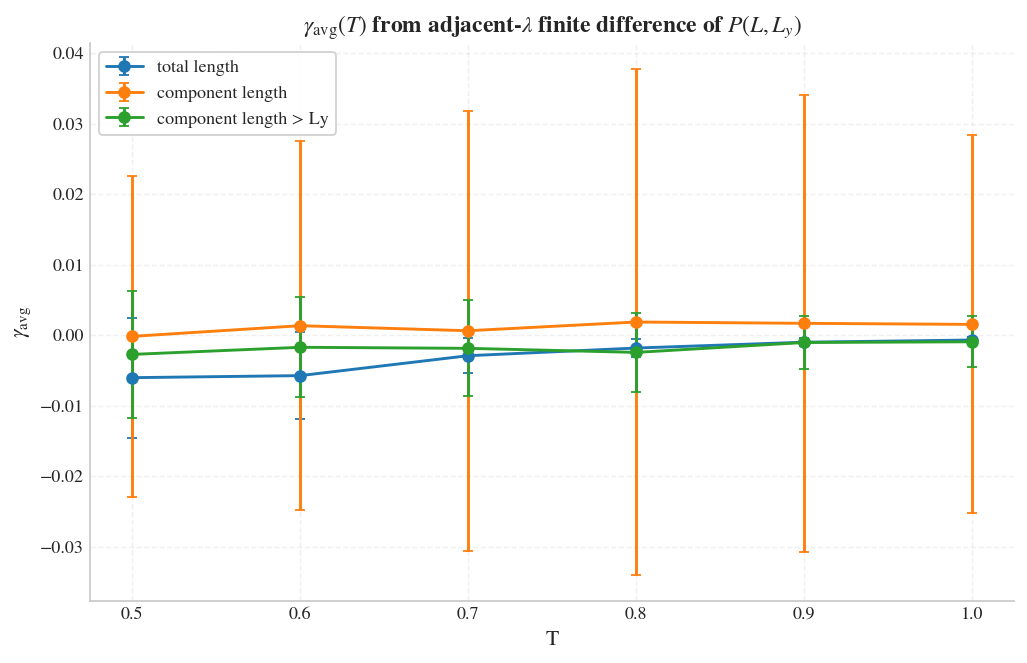

method    T  gamma_avg  gamma_std_over_lambda_pairs  \
0        component length  0.5  -0.000142                     0.022730   
1        component length  0.6   0.001369                     0.026147   
2        component length  0.7   0.000656                     0.031219   
3        component length  0.8   0.001894                     0.035936   
4        component length  0.9   0.001707                     0.032444   
5        component length  1.0   0.001554                     0.026820   
6   component length > Ly  0.5  -0.002701                     0.009018   
7   component length > Ly  0.6  -0.001692                     0.007079   
8   component length > Ly  0.7  -0.001840                     0.006786   
9   component length > Ly  0.8  -0.002417                     0.005575   
10  component length > Ly  0.9  -0.001012                     0.003796   
11  component length > Ly  1.0  -0.000910                     0.003608   
12           total length  0.5  -0.006000                     0.008501   
13           total length  0.6  -0.005710                     0.006119   
14           total length  0.7  -0.002887                     0.002497   
15           total length  0.8  -0.001798                     0.001330   
16           total length  0.9  -0.000972                     0.000574   
17           total length  1.0  -0.000661                     0.000421   

    n_lambda_pairs  
0               40  
1               40  
2               40  
3               40  
4               40  
5               40  
6               40  
7               40  
8               40  
9               40  
10              40  
11              40  
12              40  
13              40  
14              40  
15              40  
16              40  
17              40

In [8]:
# --- Gamma from adjacent-lambda finite difference dP(L,Ly)/dLy, averaged over lambda pairs ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

if "apply_plot_style" not in globals():
    def apply_plot_style():
        plt.style.use("seaborn-v0_8-whitegrid")
        plt.rcParams.update({
            "figure.dpi": 130,
            "savefig.dpi": 300,
            "axes.titlesize": 13,
            "axes.titleweight": "semibold",
            "axes.labelsize": 12,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "grid.alpha": 0.28,
            "grid.linestyle": "--",
            "legend.frameon": True,
            "legend.framealpha": 0.9,
            "legend.fancybox": True,
            "legend.edgecolor": "0.8",
            "mathtext.fontset": "stix",
            "font.family": "STIXGeneral",
        })

apply_plot_style()

if "k_B" not in globals():
    k_B = 1.0

if "base_dir" in globals():
    fd_base_dir = Path(base_dir)
else:
    fd_candidates = [Path("../results") / "analysis", Path("results") / "analysis"]
    fd_base_dir = next((p for p in fd_candidates if p.exists()), fd_candidates[0])

if not fd_base_dir.exists():
    raise RuntimeError(f"Results directory not found: {fd_base_dir}")

if "load_ly_map" not in globals() or "lambda_key" not in globals():
    raise RuntimeError("Run earlier cells first to define load_ly_map and lambda_key.")

if "rebin_intervals" not in globals():
    def rebin_intervals(intervals, edges):
        dens = np.zeros(len(edges) - 1, dtype=float)
        for lo, hi, d in intervals:
            if not np.isfinite(d) or d <= 0:
                continue
            seg_lo = max(lo, edges[0])
            seg_hi = min(hi, edges[-1])
            if seg_hi <= seg_lo:
                continue
            i0 = max(0, np.searchsorted(edges, seg_lo, side="right") - 1)
            i1 = min(len(edges) - 2, np.searchsorted(edges, seg_hi, side="left"))
            for i in range(i0, i1 + 1):
                a = max(seg_lo, edges[i])
                b = min(seg_hi, edges[i + 1])
                if b > a:
                    dens[i] += d * (b - a) / (edges[i + 1] - edges[i])
        return dens

if "hist_method_specs" in globals():
    fd_method_specs = [(item[0], item[1]) for item in hist_method_specs if len(item) >= 2]
else:
    fd_method_specs = [
        ("paired edge length", "ab_network_pair_length_hist.csv"),
        ("component length > Ly", "ab_network_component_length_gt_Ly_hist.csv"),
        ("component length", "ab_network_component_length_hist.csv"),
    ]

# Backward-compatible filename mapping (some runs use total_length instead of pair_length)
hist_fallback_map = {
    "ab_network_pair_length_hist.csv": "ab_network_total_length_hist.csv",
    "ab_network_total_length_hist.csv": "ab_network_pair_length_hist.csv",
}


def parse_lambda_from_dir(lambda_dir: Path):
    try:
        return float(lambda_dir.name.split("_", 1)[1])
    except Exception:
        return np.nan


def find_hist_path(lambda_dir: Path, hist_name: str):
    p = lambda_dir / hist_name
    if p.exists():
        return p
    alt = hist_fallback_map.get(hist_name)
    if alt is not None:
        p_alt = lambda_dir / alt
        if p_alt.exists():
            return p_alt
    return None


def hist_df_to_intervals(df: pd.DataFrame):
    required = {"bin_left", "bin_right", "count"}
    if not required.issubset(df.columns):
        return []

    df2 = df[["bin_left", "bin_right", "count"]].copy()
    df2 = df2.replace([np.inf, -np.inf], np.nan).dropna()
    if df2.empty:
        return []

    widths = df2["bin_right"].to_numpy(dtype=float) - df2["bin_left"].to_numpy(dtype=float)
    counts = df2["count"].to_numpy(dtype=float)

    good = (widths > 0) & (counts >= 0) & np.isfinite(widths) & np.isfinite(counts)
    if not np.any(good):
        return []

    left = df2["bin_left"].to_numpy(dtype=float)[good]
    right = df2["bin_right"].to_numpy(dtype=float)[good]
    counts = counts[good]
    widths = widths[good]

    total_count = np.sum(counts)
    if not np.isfinite(total_count) or total_count <= 0:
        return []

    dens = counts / (total_count * widths)
    intervals = [(float(lo), float(hi), float(d)) for lo, hi, d in zip(left, right, dens) if np.isfinite(d) and d >= 0]
    intervals.sort(key=lambda x: x[0])
    return intervals


def gamma_from_adjacent_pair(rec_i, rec_j, t_val):
    ly_i = float(rec_i["ly"])
    ly_j = float(rec_j["ly"])
    dly = ly_j - ly_i
    if not np.isfinite(dly) or abs(dly) <= 1e-12:
        return None

    edges = np.unique(np.array(
        [x for seg in rec_i["intervals"] for x in (seg[0], seg[1])] +
        [x for seg in rec_j["intervals"] for x in (seg[0], seg[1])],
        dtype=float,
    ))
    edges = edges[np.isfinite(edges)]
    if edges.size < 2:
        return None

    p_i = rebin_intervals(rec_i["intervals"], edges)
    p_j = rebin_intervals(rec_j["intervals"], edges)

    widths = np.diff(edges)
    if np.any(widths <= 0):
        return None

    dP_dLy = (p_j - p_i) / dly

    # Weighted average over L using P(L, Ly_i) as the integration core.
    core = p_i
    core_mass = np.sum(core * widths)
    if not np.isfinite(core_mass) or core_mass <= 0:
        return None

    avg_dP_dLy = float(np.sum(core * dP_dLy * widths) / core_mass)
    gamma_val = float(-k_B * t_val * avg_dP_dLy)

    return {
        "delta_ly": float(dly),
        "avg_dP_dLy": avg_dP_dLy,
        "gamma": gamma_val,
        "core_mass": float(core_mass),
        "L_min": float(edges[0]),
        "L_max": float(edges[-1]),
    }


pair_rows = []
avg_rows = []
fd_gamma_by_method = {label: [] for label, _ in fd_method_specs}

for t_dir in sorted(fd_base_dir.glob("T_*")):
    try:
        t_val = float(t_dir.name.split("_", 1)[1])
    except Exception:
        continue

    ly_map = load_ly_map(t_val, t_dir)
    if not ly_map:
        continue

    for method_label, hist_name in fd_method_specs:
        lambda_records = []

        for lambda_dir in sorted(t_dir.glob("lambda_*")):
            lam_val = parse_lambda_from_dir(lambda_dir)
            if not np.isfinite(lam_val):
                continue

            ly_val = ly_map.get(lambda_key(lam_val))
            if ly_val is None or not np.isfinite(ly_val):
                continue

            hist_path = find_hist_path(lambda_dir, hist_name)
            if hist_path is None:
                continue

            try:
                df_hist = pd.read_csv(hist_path)
            except Exception:
                continue

            intervals = hist_df_to_intervals(df_hist)
            if not intervals:
                continue

            lambda_records.append({
                "lambda": float(lam_val),
                "ly": float(ly_val),
                "intervals": intervals,
                "hist_path": str(hist_path),
            })

        lambda_records = sorted(lambda_records, key=lambda r: r["lambda"])
        if len(lambda_records) < 2:
            continue

        gamma_vals = []

        for rec_i, rec_j in zip(lambda_records[:-1], lambda_records[1:]):
            out = gamma_from_adjacent_pair(rec_i, rec_j, t_val)
            if out is None:
                continue

            gamma_vals.append(out["gamma"])
            pair_rows.append({
                "method": method_label,
                "T": float(t_val),
                "lambda_i": rec_i["lambda"],
                "lambda_j": rec_j["lambda"],
                "ly_i": rec_i["ly"],
                "ly_j": rec_j["ly"],
                "delta_ly": out["delta_ly"],
                "avg_dP_dLy": out["avg_dP_dLy"],
                "gamma": out["gamma"],
                "core_mass": out["core_mass"],
                "L_min": out["L_min"],
                "L_max": out["L_max"],
                "hist_path_i": rec_i["hist_path"],
                "hist_path_j": rec_j["hist_path"],
            })

        if gamma_vals:
            gamma_vals = np.asarray(gamma_vals, dtype=float)
            gamma_mean = float(np.mean(gamma_vals))
            gamma_std = float(np.std(gamma_vals, ddof=1)) if gamma_vals.size > 1 else 0.0

            avg_rows.append({
                "method": method_label,
                "T": float(t_val),
                "gamma_avg": gamma_mean,
                "gamma_std_over_lambda_pairs": gamma_std,
                "n_lambda_pairs": int(gamma_vals.size),
            })
            fd_gamma_by_method[method_label].append((float(t_val), gamma_mean, gamma_std))

if not avg_rows:
    raise RuntimeError("No finite-difference gamma values computed. Check histogram files and Ly maps.")

fd_out_dir = fd_base_dir / "summary_plots" / "gamma_from_adjacent_lambda_dP_dLy"
fd_out_dir.mkdir(parents=True, exist_ok=True)

df_pairs = pd.DataFrame(pair_rows).sort_values(["method", "T", "lambda_i"]).reset_index(drop=True)
df_avg = pd.DataFrame(avg_rows).sort_values(["method", "T"]).reset_index(drop=True)

out_pairs = fd_out_dir / "gamma_by_adjacent_lambda_pairs_from_dP_dLy.csv"
out_avg = fd_out_dir / "gamma_vs_T_avg_over_adjacent_lambda_pairs_from_dP_dLy.csv"

df_pairs.to_csv(out_pairs, index=False)
df_avg.to_csv(out_avg, index=False)
print(f"Saved {out_pairs}")
print(f"Saved {out_avg}")

fig, ax = plt.subplots(figsize=(8, 5.2))
for method_label, _ in fd_method_specs:
    pts = sorted(fd_gamma_by_method.get(method_label, []), key=lambda x: x[0])
    if not pts:
        continue
    t_vals = [p[0] for p in pts]
    g_vals = [p[1] for p in pts]
    g_errs = [p[2] for p in pts]
    ax.errorbar(t_vals, g_vals, yerr=g_errs, marker='o', capsize=3, linewidth=1.6, label=method_label)

ax.set_title(r'$\gamma_{\mathrm{avg}}(T)$ from adjacent-$\lambda$ finite difference of $P(L, L_y)$')
ax.set_xlabel('T')
ax.set_ylabel(r'$\gamma_{\mathrm{avg}}$')
ax.legend()
ax.grid(True, alpha=0.28, ls='--')
fig.tight_layout()

out_plot = fd_out_dir / "gamma_vs_T_avg_over_adjacent_lambda_pairs_from_dP_dLy.png"
fig.savefig(out_plot, dpi=300)
print(f"Saved {out_plot}")
plt.show()

df_avg
